In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sys
import shapely
import Helper_Methods as hm
from scipy.spatial import cKDTree
import numpy as np
import rasterstats
import rasterio
from rasterio.plot import show
import georaster
from PIL import Image
from PIL.TiffTags import TAGS
from osgeo import gdal
import datetime as dt
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os.path

In [2]:
route_data_dir = "./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/"

In [3]:
def query_route_id(shortname, route_data_path):
    '''
    query_route_id takes in a route's shortname and path to the compiled route datafile,
    and returns the shortname's route_id as an int. 
    '''
    route_id_table = pd.read_csv(route_data_path)
    route_list = list(route_id_table['route_short_name'])
    route_id = (route_id_table[route_id_table['route_short_name'] == str(shortname)].reset_index(drop=True))['route_id'][0]
    return route_id

In [4]:
def query_possible_shapes(route_id, shape_data_path):
    '''
    query_routes takes a route id and the path to the shape data, 
    and returns a list of the possible shape ids for that route.
    '''
    trip_table = pd.read_csv(shape_data_path)
    route_trips = trip_table[trip_table['route_id'] == route_id].reset_index(drop=True)
    possible_shapes = route_trips['shape_id'].unique()
    return possible_shapes

In [5]:
# Get the route ID for the selected route shortname
selected_route = '40'
route_data_path = route_data_dir + "routes.txt"
route_id = query_route_id(selected_route, route_data_path)

# Get the possible shapes the route can take
shape_data_path = route_data_dir + "trips.txt"
possible_shapes = query_possible_shapes(route_id, shape_data_path)

In [6]:
def query_shape(shape_num, shape_table_dir, fwd_flag = True):
    '''
    query_shape takes in a shape number, shape lookup directory, and returns the 
    corresponding geodataframe of that sequence. Distance is in km.
    '''
    shape_table = pd.read_csv(shape_table_dir)
    trip_shape = shape_table[shape_table['shape_id'] == shape_num]
    trip_geom = trip_shape.apply(lambda x: shapely.Point(x.shape_pt_lon, x.shape_pt_lat), axis=1)
    trip_dist = trip_shape['shape_dist_traveled']*0.0003048
    gdf = gpd.GeoDataFrame(data=trip_dist, geometry=trip_geom)
    gdf['sequence'] = trip_shape['shape_pt_sequence']
    if fwd_flag:
        return gdf
    else:
        return gdf.iloc[::-1]

In [7]:
shape_table_path = route_data_dir + "shapes.txt"
shape = query_shape(possible_shapes[0], shape_table_path)
shape = shape[::]

In [8]:
def haversine_formula(x1, y1, x2, y2):
    '''
    haversine_formula takex the latitude and longitude of two separate points,
    and calculates the distance in kilometers between those two points as a crow flies.
    '''
    lat1=np.radians(x1)
    lon1=np.radians(y1)
    lat2=np.radians(x2)
    lon2=np.radians(y2)
    R = 6373.0
    dlon=lon2-lon1
    dlat=lat2-lat1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    
    return distance

In [12]:
def query_stops(shape, stop_table_path):
    '''
    query_stops takes in a shape gdf for a given route, and a path to
    all stop ids and geometry, and then returns a list of stop id's in the order the
    bus will arrive.
    '''
    shape_bounds = hm.get_bounding_box(shapely.LineString(list(shape['geometry'])))
    stop_table = pd.read_csv(stop_table_path)
    stop_table['geometry'] = stop_table.apply(lambda x: shapely.Point(x.stop_lon, x.stop_lat), axis=1)
    stop_table = gpd.GeoDataFrame(stop_table).set_crs(epsg = 4326).to_crs(epsg = 4326)
    stop_table = stop_table[stop_table['geometry'].apply(lambda x: shape_bounds.contains(x)) == True]
    # check for stops within a set distance of each geometry point
    stop_id_list = []
    for index, row in shape.iterrows():
        route_pt = row.geometry
        stop_table['dist'] = stop_table.geometry.apply(lambda x: haversine_formula(x.y, x.x, route_pt.y, route_pt.x)*1000)
        closest_stop = stop_table[stop_table['dist'] == stop_table['dist'].min()].reset_index().iloc[0]
        
        stop_id_list.append(int(closest_stop['dist']<10)*closest_stop['stop_id'] - int(closest_stop['dist']>10))
    #shape['stop_id'] = shape.apply(lambda x: x.geometry, axis=1)
    return stop_id_list

In [13]:
stop_table_path = route_data_dir + "stops.txt"
shape['stop_id'] = query_stops(shape, stop_table_path)

In [14]:
def get_rasterfiles(dir_path):
    '''
    get all non-reprojected rasterfiles in a given directory. Returns a pandas series of paths.
    '''
    rasterfiles_raw = pd.Series(os.listdir(dir_path))
    rasterfiles_raw = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('tif' in (x.split("."))[-1]))].reset_index(drop='true')
    rasterfiles = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('reproject' not in x))].reset_index(drop='true')
    rasterfiles = rasterfiles.apply(lambda x: "{}{}".format(dir_path, x))
    return rasterfiles


def reproject_rasterfiles(filepath_sequence, target_crs='EPSG:4326'):
    '''
    Take the filepaths for raster files in a pandas series, and reproject them
    to a target CRS, defaulting to EPSG:4326
    '''
    for path in list(filepath_sequence):
        #CHECK IF THE REPROJECTED FILE EXISTS
        if (os.path.isfile(path + '_reproject.tif')==False):
            with rasterio.open(path) as src:
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                with rasterio.open(path+'_reproject.tif', 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs,
                            resampling=Resampling.nearest)
                    
    return filepath_sequence.astype(str) + "_reproject.tif"


def query_raster_elevation(gtiff_dir_ser, geometry):
    '''
    query_raster_elevation takes a series of geotiff directories and a geometry series of points,
    and returns a series of the elevations corresponding to each point in the series. 
    
    The directory series of geotiffs needs to be in the correct projection to match the geometry,
    and needs to contain the geometric points to query the elevation. Returns elevation in kilometers.
    '''
    data_dict = {}
    route_ll = (geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
    for path in list(gtiff_dir_ser):
        with rasterio.open(path) as img:
            route = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered = route[route.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            for index in filtered.index:
                data_dict[index] = filtered[index][0]
    pddf = pd.Series(data_dict).apply(float)
    return pddf.values/1000

In [15]:
dsm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/"
dtm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dtm/"
DSM_rasters_raw = get_rasterfiles(dsm_raster_path)
DTM_rasters_raw = get_rasterfiles(dtm_raster_path)

reprojected_DSMs = reproject_rasterfiles(DSM_rasters_raw)
reprojected_DTMs = reproject_rasterfiles(DTM_rasters_raw)

shape['DSM'] = query_raster_elevation(reprojected_DSMs, shape['geometry'])
shape['DTM'] = query_raster_elevation(reprojected_DTMs, shape['geometry'])


In [16]:
def query_distance_traveled(geometry_series):
    '''
    query_distance_traveled takes in a series of points,
    and then calculates the distance traveled from point to point, in kilometers.
    '''
    currents = geometry_series
    nexts = geometry_series.shift(1)
    data = pd.concat([currents, nexts], axis=1, keys=['current', 'next']).reset_index(drop=True)
    initial_point = list(data['current'])[0]
    data.loc[0, 'next'] = initial_point
    dXs = data.apply(lambda x: haversine_formula(x.current.y, x.current.x, x.next.y, x.next.x), axis=1)
    return dXs.values

In [17]:
shape['have_dx'] = query_distance_traveled(shape['geometry'])
shape['have_dist'] = shape['have_dx'].cumsum()

In [18]:
def combine_elevation_data(shape, max_grade=7.5):
    '''
    combine_elevation_data takes a shape dataframe, and then uses the information
    within it to calculate a filtered elevation based on removing sudden spikes in grade.
    '''
    data = pd.concat([shape['DSM'], shape['have_dx']], axis=1, keys=['dsm', 'dx']).reset_index(drop=True)
    data['rolling_dsm'] = (data['dsm'].rolling(7).median()).shift(-3)
    data['dsm_dy'] = data['dsm'].diff()

    # if the grade exceeds the maximum, use the rolling median as the grade instead.
    filtered = data.apply(lambda x: (int(abs(x.dsm_dy/x.dx*100)>max_grade) * x.rolling_dsm) + (int(abs(x.dsm_dy/x.dx*100)<=max_grade)*x.dsm), axis=1)
    #filtered = pd.Series(scipy.signal.savgol_filter(filtered, 15, 3, axis = 0))
    return filtered.values

In [19]:
shape['filtered_elevation'] = combine_elevation_data(shape)
shape['filtered_grade'] = (shape['filtered_elevation'].diff()/shape['have_dx']*100).clip(7.5, -7.5) # Account for grade not actually being 200%.

/tmp/ipykernel_51624/652157004.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  filtered = data.apply(lambda x: (int(abs(x.dsm_dy/x.dx*100)>max_grade) * x.rolling_dsm) + (int(abs(x.dsm_dy/x.dx*100)<=max_grade)*x.dsm), axis=1)


In [40]:
'''
Primarily Xcelsior models.
Width 2.59 Meters
Height 3.20 Meters -or- 3.38 meters (non-diesel)
Weight: 35 (11,100 - 13,300)
        40 (11,800 - 13,800)
        60 (17,700 - 20,600)
        
Air conditioner - thermo king TE18 - Nominal power draw on 380 is 26 amps.
'''

'\nPrimarily Xcelsior models.\nWidth 2.59 Meters\nHeight 3.20 Meters -or- 3.38 meters (non-diesel)\nWeight: 35 (11,100 - 13,300)\n        40 (11,800 - 13,800)\n        60 (17,700 - 20,600)\n        \nAir conditioner - thermo king (INTERNAL BATTERY - SEPARATE DEVICE\n'

In [41]:
class Bus:
    def __init__():
        # Inherent
        self.width
        self.height
        self.mass
        self.area
        self.inertial_factor
        self.friction_coefficient
        self.motor_efficiency
        self.inverter_efficiency
        self.max_power
        self.max_velocity
        self.regen_percent
        self.acceleration_profile
        self.braking_acceleration
        self.asymptote_acceleration
        self.id
        
        # variable
        self.bearing
        self.velocity
        self.n_passengers
        self.mass_per_passenger
        self.status
        self.total_mass
        self.aux_load
        self.braking_aggression
        
        #drag(self.velocity, external conditions)
        #accelerate(a set distance, external conditions)
        #brake(a set distance, external conditions)
        #maintain(a set distance, external conditions)

class Trip:
    def __init__():
        #inherent:
        self.geometry
        self.stops
        self.elevation
        self.ridership_changes
    
    # calculate the frictional forces of the route, which is based on the bus
    # calculate the elevational acceleration of the route based on the bus

In [21]:
def model_lookup(vehicle_id_num, bus_class_table_dir):
    bus_class_table = pd.read_csv(bus_class_table_dir)
    return bus_class_table[bus_class_table.apply(lambda x: str(vehicle_id_num) in str(x['fnums']), axis=1)].reset_index(drop=True)['Model'][0]

In [35]:
bus_id_table = pd.read_csv('./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_id_data.csv')
bus_class_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_classes.csv"
route_bus_id_table = bus_id_table[bus_id_table['route_id'].apply(str) == str(route_id)].reset_index(drop=True)

try: 
    route_bus_id_table['bus_model'] = route_bus_id_table.apply(lambda x: model_lookup(x['vehicle_id'], bus_class_path), axis=1)
except:
    print("No Models in database for route_id {}".format(route_id))
possible_bus_models = route_bus_id_table['bus_model'].unique()

model_url = "https://cptdb.ca" + possible_bus_models[0][1:-1].split(",")[1][2:-1]
#"https://cptdb.ca"
"https://en.wikipedia.org/wiki/Special:Search?go=Go&search=%27{}%27&ns0=1".format(model_url.split("/")[-1])

'https://en.wikipedia.org/wiki/Special:Search?go=Go&search=%27New_Flyer_Industries_XDE60%27&ns0=1'

In [543]:
'''
fig, ax = plt.subplots(1, figsize = (15, 15), dpi=300)



seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]


seattle.plot(color='#BDBDBD', ax=ax, zorder = 20, alpha = .2)
gpd.GeoDataFrame(shape).plot(ax=ax, zorder=25, markersize=.2)


#ax.set_xlim(-122.4, -122.375)
#ax.set_ylim(47.65, 47.675)
'''

'\nfig, ax = plt.subplots(1, figsize = (15, 15), dpi=300)\n\n\n\nseattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")\n\n# filter out all \'water\' zones in the data for clarity\nseattle = seattle[(seattle[\'WATER\'] != 1)]\n\n\nseattle.plot(color=\'#BDBDBD\', ax=ax, zorder = 20, alpha = .2)\ngpd.GeoDataFrame(shape).plot(ax=ax, zorder=25, markersize=.2)\n\n\n#ax.set_xlim(-122.4, -122.375)\n#ax.set_ylim(47.65, 47.675)\n'

In [408]:
def query_theoretical_times(shape, stop_time_path):
    '''
    query_theoretical_times takes in a shape gdf for a given route, 
    a path to the stop times, and then returns a list of time benchmarks at each stop
    in order in units of seconds.
    
    NONFUNCTIONAL, DATASET HAS NO METHOD FOR CONNECTING TO DATA
    '''
    stop_times = pd.read_csv(stop_time_path)
    
    def try_dataframe_query(df):
        try:
            print(df.columns)
            return dict(df.iloc[0])['arrival_time']
        except:
            return None
        
    def try_strptime(val):
        try:
            return dt.datetime.strptime(str(val), "%H:%M:%S")
        except:
            return None
        
    time_benchmarks = shape.apply(lambda x: try_dataframe_query(stop_times[stop_times['stop_id'] == x.stop_id].reset_index()), axis=1)
    time_benchmarks = time_benchmarks.apply(lambda x: try_strptime(x))
    init_time = time_benchmarks.iloc[0]
    time_benchmarks = (time_benchmarks)
    return time_benchmarks

In [54]:
stop_time_table_path = route_data_dir + "stop_times.txt"
shape['time_bnch'] = query_theoretical_times(shape, stop_time_table_path)


Index(['index', 'trip_id', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type',
       'shape_dist_traveled', 'timepoint'],
      dtype='object')
Index(['index', 'trip_id', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type',
       'shape_dist_traveled', 'timepoint'],
      dtype='object')
Index(['index', 'trip_id', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type',
       'shape_dist_traveled', 'timepoint'],
      dtype='object')
Index(['index', 'trip_id', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type',
       'shape_dist_traveled', 'timepoint'],
      dtype='object')
Index(['index', 'trip_id', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type',
       'sha

In [43]:
shape[~shape['time_bnch'].apply(np.isnan)]

,shape_dist_traveled,geometry,sequence,stop_id,time_bnch
73145,0.0,POINT (-122.32793 47.70231),1,35318,1900-01-01 23:00:00
73154,1811.6,POINT (-122.32846 47.69773),10,17697,1900-01-01 23:01:20
73155,1812.6,POINT (-122.32846 47.69773),11,17697,1900-01-01 23:01:20
73166,2988.9,POINT (-122.33051 47.69593),22,17698,1900-01-01 23:02:11
73173,5297.6,POINT (-122.33502 47.69927),29,17710,1900-01-01 23:03:53
73190,6809.2,POINT (-122.33388 47.70318),46,17730,1900-01-01 23:04:59
73191,6824.3,POINT (-122.33390 47.70322),47,17730,1900-01-01 23:04:59
73193,7387.1,POINT (-122.33392 47.70476),49,17740,1900-01-01 23:05:25
73201,8958.2,POINT (-122.33457 47.70847),57,17755,1900-01-01 23:06:34
73202,8967.2,POINT (-122.33461 47.70846),58,17755,1900-01-01 23:06:34


In [274]:
rider_data = pd.read_csv(ridership_data_path)
rider_data['STOP_ID'] = rider_data['STOP_ID'].apply(int)
shape.apply(lambda x: ride_data[ride_data['TRANS_LINK_ID'] == int(x.stop_id)], axis=1)

73145            Route Dir   Trip_ID InOut E/L  STOP_ID...
73146    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73147    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73148    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73149    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
                               ...                        
73592    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73593    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73594    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73595    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
73596    Empty DataFrame
Columns: [Route, Dir, Trip_ID,...
Length: 452, dtype: object

In [263]:
def query_rider_change(shape, ridership_data_path):
    ride_data = pd.read_csv(ridership_data_path)
    
    def try_rider_query(df):
        try:
            return (float(df.iloc[0]['AveOn']) - float(df.iloc[0]['AveOff'])
        except:
            return None
        
    riderchanges = shape.apply(lambda x: try_rider_query(ride_data[ride_data['STOP_ID'] == x.stop_id]), axis=1)
    return riderchanges

In [264]:
ridership_data_path = route_data_dir + "ridership.csv"
query_rider_change(shape, ridership_data_path)

73145   NaN
73146   NaN
73147   NaN
73148   NaN
73149   NaN
         ..
73592   NaN
73593   NaN
73594   NaN
73595   NaN
73596   NaN
Length: 452, dtype: float64

In [ ]:
def query_theoretical_passengers(shape, ridership_path)

#### Code for requesting live-data and bus id's

In [548]:
import urllib.request, json
bus_id_table = []
# ping kcm vehicle real time database
with urllib.request.urlopen('https://s3.amazonaws.com/kcm-alerts-realtime-prod/vehiclepositions_pb.json') as url:
    data = json.load(url)
    for entry in data['entity']:
        data_dict = {'route_id':entry['vehicle']['trip']['route_id'],
                     'vehicle_id':entry['vehicle']['vehicle']['id'],
                     'trip_id':entry['vehicle']['trip']['trip_id'],
                     'direction':entry['vehicle']['trip']['direction_id']}
        bus_id_table.append(data_dict)
bus_id_table = pd.DataFrame(bus_id_table)
bus_id_table.to_csv('./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_id_data2.csv')

#### Code for requesting bus class data:

In [591]:
import requests
from bs4 import BeautifulSoup
url = "https://cptdb.ca/wiki/index.php?title=King_County_Metro"
resp = requests.get(url)
bus_list = []
if resp.status_code==200:
    soup=BeautifulSoup(resp.text, 'html.parser')
    l=soup.find_all("table", {"class":"sortable"})[:1]
    for item in l:
        tr_s = item.find_all("tr")
        key_header = tr_s[0].find_all("th")
        keys = []
        for header in key_header:
            keys.append((header.text).split("\n")[0])
        entries = tr_s[1:]
        for entry in entries:
            data_dict = {}
            vals = entry.find_all("td")
            for i in range(len(vals)):
                item_url = None
                try:
                    item_url = (vals[i].a)['href']
                except:
                    item_url = None
                
                data_dict[keys[i]] = [(vals[i].text).split("\n")[0], item_url]
                
            bus_list.append(data_dict)
bus_classes = pd.DataFrame(bus_list)
#bus_classes['min_range'] = bus_classes['Fleet number(s)'].apply(lambda x: int((x.split("-"))[0]))
#bus_classes.to_csv('./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_classes.csv')
def range_parser(fleetnum_string):
    isolateds = fleetnum_string.split(",")
    running_list = []
    for isolate in isolateds:
        ranges = isolateds[0].split("-")
        bottom = ranges[0]
        try:
            top = ranges[1]
        except:
            top=bottom
        list_nums = list(np.arange(int(bottom), int(top), 1))
        if len(list_nums)<1 : 
            list_nums = [bottom]
        running_list.extend(list_nums)
    return running_list
        
bus_classes['fnums'] = bus_classes['Fleet number(s)'].apply(lambda x: range_parser(x[0]))
bus_classes.to_csv('./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_classes.csv')

#### 

In [592]:
def model_lookup(vehicle_id_num, bus_class_table_dir):
    bus_class_table = pd.read_csv(bus_class_table_dir)
    return bus_class_table[bus_class_table.apply(lambda x: str(vehicle_id_num) in str(x['fnums']), axis=1)].reset_index(drop=True)['Model'][0]

In [623]:
bus_id_table = pd.read_csv('./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_id_data.csv')
bus_class_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Route_Data/bus_classes.csv"
route_bus_id_table = bus_id_table[bus_id_table['route_id'].apply(str) == str(route_id)].reset_index(drop=True)
route_bus_id_table['bus_model'] = route_bus_id_table.apply(lambda x: model_lookup(x['vehicle_id'], bus_class_path), axis=1)
possible_bus_models = route_bus_id_table['bus_model'].apply(lambda x: str(x[1:-1]).split(',')[0][1:-1]).unique()

In [621]:
possible_bus_models

array(["'/wiki/index.php/New_Flyer_Industries_XDE60",
       "'/wiki/index.php/New_Flyer_Industries_DE60LFR"], dtype=object)

In [22]:
def shape_lookup(shape_num, shape_table_dir):
    shape_table = pd.read_csv(shape_table_dir)
    trip_shape = shape_table[shape_table['shape_id'] == shape_num]
    trip_geom = trip_shape.apply(lambda x: shapely.Point(x.shape_pt_lon, x.shape_pt_lat), axis=1)
    trip_dist = trip_shape['shape_dist_traveled']
    gdf = gpd.GeoDataFrame(data=trip_dist, geometry=trip_geom)
    gdf['sequence'] = trip_shape['shape_pt_sequence']
    return gdf

In [23]:
shape_table_path = route_data_dir + "shapes.txt"
shape_lookup(10002005, shape_table_path)

,shape_dist_traveled,geometry,sequence
0,0.0,POINT (-122.28177 47.61214),1
1,5.8,POINT (-122.28178 47.61214),2
2,13.5,POINT (-122.28183 47.61215),3
3,22.0,POINT (-122.28185 47.61214),4
4,45.0,POINT (-122.28192 47.61210),5
...,...,...,...
361,35882.8,POINT (-122.36565 47.64312),362
362,36028.7,POINT (-122.36623 47.64312),363
363,36170.9,POINT (-122.36625 47.64273),364
364,36174.2,POINT (-122.36625 47.64273),365


In [9]:
shape_table = pd.read_csv(route_data_dir + "shapes.txt")
trip_shape = shape_table[shape_table['shape_id'] == selected_trip['shape_id']]
# reformat the trip shape to something readable:
def reformat_trip_shape(trip_shape):
    trip_shape_copy = trip_shape.copy()
    trip_geom = trip_shape_copy.apply(lambda x: shapely.Point(x.shape_pt_lon, x.shape_pt_lat), axis=1)
    trip_dist = trip_shape_copy['shape_dist_traveled']
    gdf = gpd.GeoDataFrame(data=trip_dist, geometry=trip_geom)
    gdf['sequence'] = trip_shape_copy['shape_pt_sequence']
    return gdf

trip_shape = reformat_trip_shape(trip_shape).reset_index(drop=True)

NameError: name 'selected_trip' is not defined

In [159]:
shape_table

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,10002005,47.612137,-122.281769,1,0.0
1,10002005,47.612144,-122.281784,2,5.8
2,10002005,47.612148,-122.281830,3,13.5
3,10002005,47.612141,-122.281853,4,22.0
4,10002005,47.612102,-122.281921,5,45.0
...,...,...,...,...,...
198890,41982005,47.673229,-122.101021,847,137846.6
198891,41982005,47.673279,-122.100990,848,137865.6
198892,41982005,47.673351,-122.100990,849,137891.1
198893,41982005,47.673569,-122.101059,850,137972.6


In [590]:
def convert_to_datetime(val):
    # make sure it isnt NaN
    try:
        datetime = dt.datetime.strptime(str(val), "%H:%M:%S")
        return datetime
    except:
        return None

In [591]:
import datetime as dt
trip_shape['stop_id'] = pd.Series(None)
stop_time_table = pd.read_csv(route_data_dir + "stop_times.txt")
stop_table = pd.read_csv(route_data_dir + "stops.txt")
stop_table['geometry'] = stop_table.apply(lambda x: shapely.Point(x.stop_lon, x.stop_lat), axis=1)
trip_stop_time_data = stop_time_table[stop_time_table['trip_id'] == selected_trip['trip_id']]
trip_shape['stop_id'] = trip_shape.apply(lambda x: trip_stop_time_data[trip_stop_time_data['stop_sequence']==x.sequence].reset_index(drop=True)['stop_id'] ,axis=1)
#trip_stop_time_data['geometry'] = trip_stop_time_data['stop_id'].apply(lambda x: stop_table[stop_table['stop_id'] == x].reset_index(drop=True)['geometry'])
trip_shape['arrival_time'] = trip_shape.apply(lambda x: trip_stop_time_data[x.stop_id == trip_stop_time_data['stop_id']].reset_index(drop=True)['arrival_time'], axis=1)
trip_shape['departure_time'] = trip_shape.apply(lambda x: trip_stop_time_data[x.stop_id == trip_stop_time_data['stop_id']].reset_index(drop=True)['departure_time'], axis=1)
trip_shape['departure_time'] = trip_shape['departure_time'].apply(convert_to_datetime)
trip_shape['arrival_time'] = trip_shape['arrival_time'].apply(convert_to_datetime)
trip_shape['target_rest_time'] = (trip_shape['departure_time'] - trip_shape['arrival_time']).apply(lambda x: x.seconds)
start_time = trip_shape['departure_time'][0]
trip_shape['target_total_time'] = trip_shape['arrival_time'].apply(lambda x: (x-start_time).seconds).cumsum()

In [592]:
import georaster

In [593]:
def get_rasterfiles(dir_path):
    '''
    get all non-reprojected rasterfiles in a given directory. Returns a pandas series of paths.
    '''
    rasterfiles_raw = pd.Series(os.listdir(dir_path))
    rasterfiles_raw = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('tif' in (x.split("."))[-1]))].reset_index(drop='true')
    rasterfiles = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('reproject' not in x))].reset_index(drop='true')
    rasterfiles = rasterfiles.apply(lambda x: "{}{}".format(dir_path, x))
    return rasterfiles

In [594]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os.path

def reproject_rasterfiles(filepath_sequence, target_crs='EPSG:4326'):
    '''
    Take the filepaths for raster files in a pandas series, and reproject them
    to a target CRS, defaulting to EPSG:4326
    '''
    for path in list(filepath_sequence):
        print(path)
        #CHECK IF THE REPROJECTED FILE EXISTS
        if (os.path.isfile(path + '_reproject.tif')==False):
            with rasterio.open(path) as src:
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                with rasterio.open(path+'_reproject.tif', 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs,
                            resampling=Resampling.nearest)
                    
    return filepath_sequence.astype(str) + "_reproject.tif"

In [595]:
def query_elevation_benchmarks(bench_data, model_path, model_prefix = ""):
    all_benchmarks = {}
    for path in list(model_path):
        with rasterio.open(path) as img:
            bench_data['raster_elev'] = list(rasterio.sample.sample_gen(img, list(bench_data['ll_tuple']), masked=True))
            filtered_benchmarks = bench_data[bench_data['raster_elev'].apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]

            for row_2, col_2 in filtered_benchmarks.iterrows():
                data_dict = {'True_elevation':col_2['ELEVATION'], '{}_Model_elevation'.format(model_prefix):col_2['raster_elev'][0]}
                all_benchmarks[row_2] = data_dict
    return all_benchmarks

In [596]:
dsm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/"
dtm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dtm/"
DSM_rasters_raw = get_rasterfiles(dsm_raster_path)
DTM_rasters_raw = get_rasterfiles(dtm_raster_path)

reprojected_DSMs = reproject_rasterfiles(DSM_rasters_raw)
reprojected_DTMs = reproject_rasterfiles(DTM_rasters_raw)

./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_100.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_101.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_102.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_103.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_104.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_105.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_106.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_86.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2

In [597]:
def query_elevation_series(gtiff_dir_ser, geometry):
    data_dict = {}
    route_ll = (geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
    for path in list(gtiff_dir_ser):
        with rasterio.open(path) as img:
            route = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered = route[route.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            for index in filtered.index:
                data_dict[index] =filtered[index]
    return pd.Series(data_dict)

In [720]:
trip_shape['DSM_elev'] = query_elevation_series(reprojected_DSMs, trip_shape['geometry']).apply(float)*.3048 # meters
trip_shape['DSM_diff'] = trip_shape['DSM_elev'].diff() # meters
trip_shape['DTM_elev'] = query_elevation_series(reprojected_DTMs, trip_shape['geometry']).apply(float)*.3048 # meters
trip_shape['roll_DSM_elev'] = (trip_shape['DSM_elev'].rolling(7).median()).shift(-3) # meters
trip_shape['next_point'] = trip_shape['geometry'].shift(1)
trip_shape.loc[0, 'next_point'] = trip_shape['geometry'][0]

In [721]:
trip_shape['DSM_diff']

0           NaN
1     -2.501925
2      0.255989
3      2.504587
4      1.653040
         ...   
348    0.509560
349    0.737815
350    0.733918
351    5.257381
352    0.630687
Name: DSM_diff, Length: 353, dtype: float64

In [722]:
def haversine_2(x1, y1, x2, y2):
    lat1=np.radians(x1)
    lon1=np.radians(y1)
    lat2=np.radians(x2)
    lon2=np.radians(y2)
    R = 6373.0
    dlon=lon2-lon1
    dlat=lat2-lat1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    
    return distance

In [723]:
trip_shape['have_dx']

0       0.000000
1       9.399753
2      13.736822
3      92.506513
4      57.311315
         ...    
348     5.377477
349     7.988192
350     7.404334
351    65.665671
352    31.168056
Name: have_dx, Length: 353, dtype: float64

In [727]:
trip_shape['have_dx'] = trip_shape.apply(lambda x: haversine_2(x.next_point.y, x.next_point.x, x.geometry.y, x.geometry.x), axis=1)*1000
trip_shape['have_dist_traveled'] = trip_shape['have_dx'].cumsum()
trip_shape['filtered_DSM_elevation'] = trip_shape['DSM_elev']
trip_shape['filtered_DSM_elevation'][1:] = trip_shape[1:].apply(lambda x: (int(abs(x.DSM_diff/x.have_dx*100)>7.5) * x.roll_DSM_elev) + (int(abs(x.DSM_diff/x.have_dx*100)<=7.5)*x.DSM_elev), axis=1)

/tmp/ipykernel_15851/3920794692.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trip_shape['filtered_DSM_elevation'][1:] = trip_shape[1:].apply(lambda x: (int(abs(x.DSM_diff/x.have_dx*100)>7.5) * x.roll_DSM_elev) + (int(abs(x.DSM_diff/x.

In [716]:
trip_shape

,shape_dist_traveled,geometry,sequence,stop_id,arrival_time,departure_time,target_rest_time,target_total_time,DSM_elev,DTM_elev,...,smooth_DSM,smooth_DTM,DTM_base_grade,DSM_base_grade,DTM_smooth_grade,DSM_smooth_grade,mean_grade,roll_DSM_elev,DSM_diff,filtered_DSM_elevation
0,0.0,POINT (-122.32906 47.59984),1,619.0,1900-01-01 17:45:00,1900-01-01 17:45:00,0.0,0.0,16.355133,13.721085,...,50.561285,43.427824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.355133
1,28.0,POINT (-122.32905 47.59992),2,NaN,NaT,NaT,NaN,NaN,13.853208,13.813109,...,49.255896,46.430354,0.328659,-8.935448,NaN,NaN,NaN,NaN,-2.501925,NaN
2,75.1,POINT (-122.32898 47.60004),3,NaN,NaT,NaT,NaN,NaN,14.109197,14.043813,...,50.113323,49.773580,0.489816,0.543501,NaN,NaN,NaN,NaN,0.255989,NaN
3,379.6,POINT (-122.32900 47.60087),4,NaN,NaT,NaT,NaN,NaN,16.613784,16.582298,...,52.492265,53.226354,0.833657,0.822524,NaN,NaN,NaN,16.628760,2.504587,16.613784
4,566.4,POINT (-122.32942 47.60130),5,NaN,NaT,NaT,NaN,NaN,18.266823,18.190206,...,55.751419,56.557529,0.860764,0.884925,NaN,NaN,0.060177,16.997561,1.653040,18.266823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,45204.4,POINT (-122.40090 47.69432),349,NaN,NaT,NaT,NaN,NaN,72.633678,72.593690,...,238.087309,238.073606,2.833969,2.754376,4.604973,2.960696,1.587715,73.623790,0.509560,73.623790
349,45228.1,POINT (-122.40095 47.69439),350,NaN,NaT,NaT,NaN,NaN,73.371494,73.333961,...,241.418970,241.361267,3.123507,3.113145,4.863725,3.248368,1.496466,74.787381,0.737815,74.787381
350,45251.4,POINT (-122.40097 47.69445),351,NaN,NaT,NaT,NaN,NaN,74.105412,74.070949,...,246.730058,246.599867,3.163037,3.149863,6.387009,4.363356,NaN,NaN,0.733918,NaN
351,45469.5,POINT (-122.40121 47.69502),352,NaN,NaT,NaT,NaN,NaN,79.362793,79.316024,...,254.398759,254.243404,2.404895,2.410537,0.852807,0.591117,NaN,NaN,5.257381,NaN


In [600]:
import scipy
def smooth_elevation(elev_series, lg:int = 43, deg:int = 3):

        # Apply the savgol filter to the points
        y_new = scipy.signal.savgol_filter(elev_series,
                   lg,
                   deg,
                   axis = 0)

        return y_new

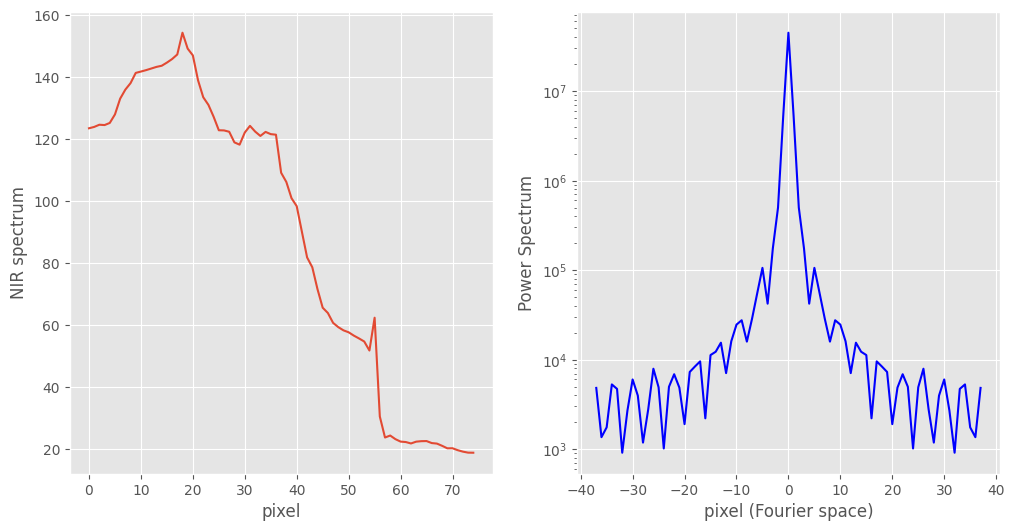

In [601]:
# Calculate the power spectrum 
imin = 25
imax = 100
subset = trip_shape['DSM_elev'][imin:imax]
ps = np.abs(np.fft.fftshift(np.fft.fft(subset)))**2
 
# Define pixel in original signal and Fourier Transform
pix = np.arange(subset.shape[0])
fpix = np.arange(ps.shape[0]) - ps.shape[0]//2
 
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(pix, subset)
    axes[0].set_xlabel('pixel')
    axes[0].set_ylabel('NIR spectrum')
    
    axes[1].semilogy(fpix, ps, 'b')
    axes[1].set_xlabel('pixel (Fourier space)')
    axes[1].set_ylabel('Power Spectrum')
    

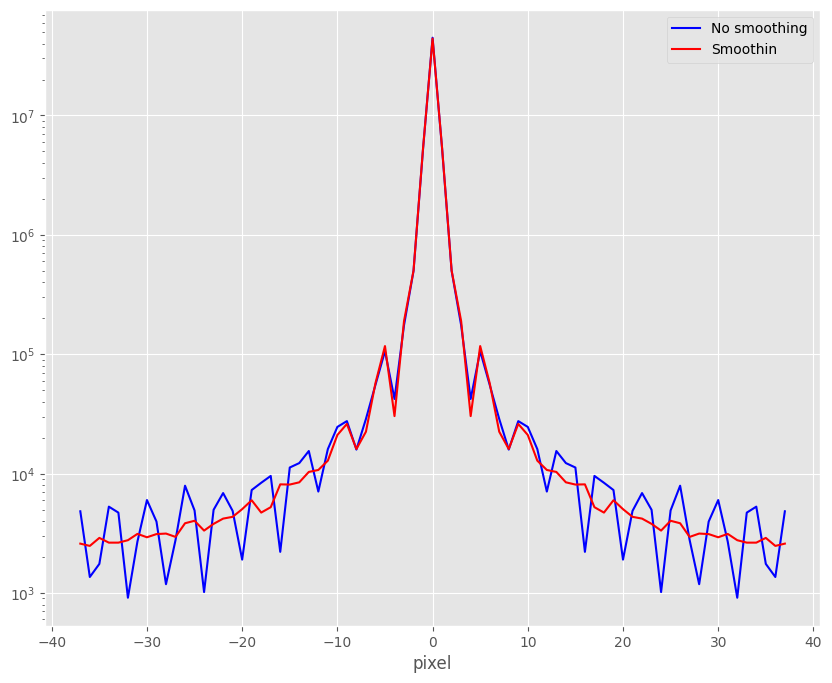

In [602]:
w = 10
p = 3
# Calculate three different smoothed spectra
X_smooth_1 = scipy.signal.savgol_filter(trip_shape['DSM_elev'], w, polyorder = p, deriv=0)
 
# Calculate the power spectra in a featureless region
ps = np.abs(np.fft.fftshift(np.fft.fft(subset)))**2
ps_1 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_1[imin:imax])))**2

 
# Define pixel in Fourier space
fpix = np.arange(ps.shape[0]) - ps.shape[0]//2
 
plt.figure(figsize=(10,8))
with plt.style.context(('ggplot')):
    plt.semilogy(fpix, ps, 'b', label = 'No smoothing')
    plt.semilogy(fpix, ps_1, 'r', label = 'Smoothin')

    plt.legend()
    plt.xlabel('pixel')

In [612]:
trip_shape['smooth_DSM'] = smooth_elevation(trip_shape['DSM_elev'], w, p)
trip_shape['smooth_DTM'] = smooth_elevation(trip_shape['DTM_elev'], w, p)

trip_shape['DTM_base_grade'] = (trip_shape['DTM_elev'].diff()/trip_shape['shape_dist_traveled'].diff()*.3048*100)[:].apply(float)
trip_shape['DSM_base_grade'] = (trip_shape['DSM_elev'].diff()/trip_shape['shape_dist_traveled'].diff()*.3048*100)[:].apply(float)
trip_shape['DTM_smooth_grade'] = (smooth_elevation(trip_shape['DTM_elev'].diff())/trip_shape['shape_dist_traveled'].diff()*.3048*100)[:].apply(float)
trip_shape['DSM_smooth_grade'] = (smooth_elevation(trip_shape['DSM_elev'].diff())/trip_shape['shape_dist_traveled'].diff()*.3048*100)[:].apply(float)

print(len(trip_shape))
# Filter by grade??
#trip_shapegrade_filter = trip_shape[trip_shape['DSM_base_grade'].apply(abs) < 9]

353


In [613]:
# It is pretty clear that attempts ot use a savisky-golay filter to reduce noise loses some amount of critical terrain thhat appears immutable. Smoothing a whole mile-long hill is not correct, remotely.

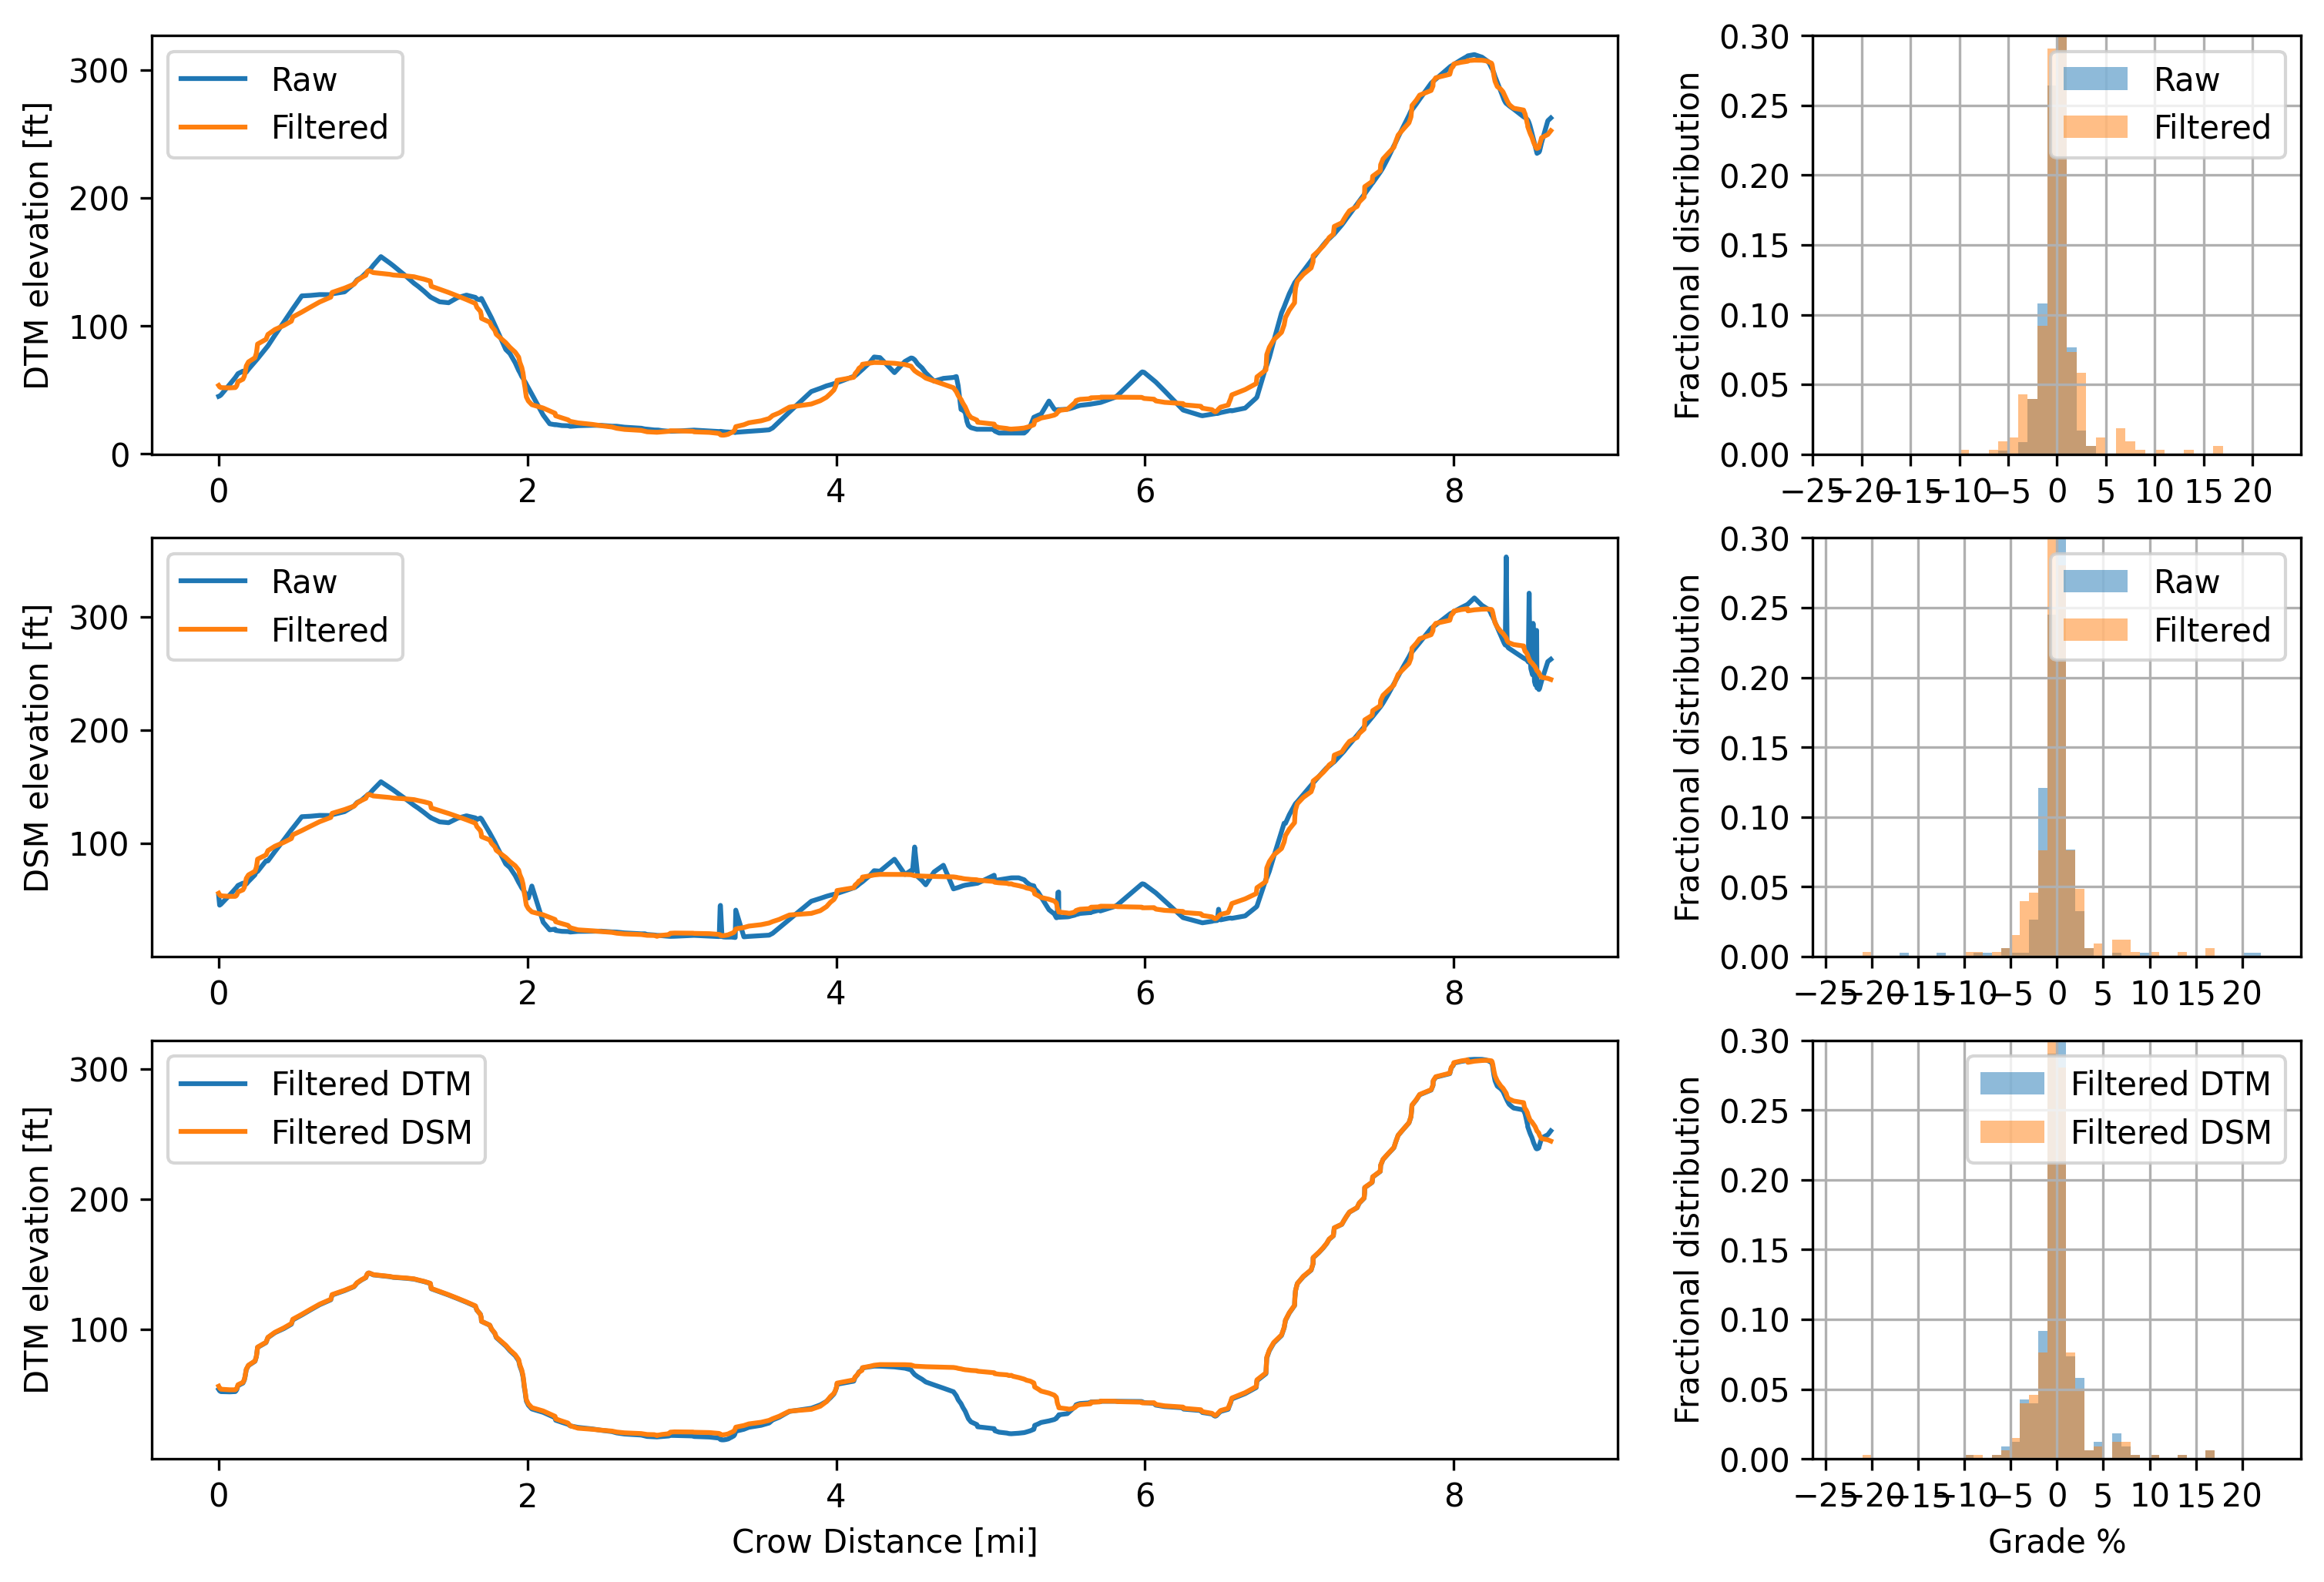

In [614]:
fig, ax = plt.subplots(3,2, figsize = (12, 8), dpi=300, gridspec_kw={'width_ratios': [3, 1]})

bins = [-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

ax[0,0].plot(trip_shape['have_dist_traveled']*.6213712, trip_shape['DTM_elev'])
ax[0,0].plot(trip_shape['have_dist_traveled']*.6213712, smooth_elevation(trip_shape['DTM_elev']))
ax[0,0].set_ylabel("DTM elevation [ft]")
ax[0,0].legend(['Raw', "Filtered"])

ax[1,0].plot(trip_shape['have_dist_traveled']*.6213712, trip_shape['DSM_elev'])
ax[1,0].plot(trip_shape['have_dist_traveled']*.6213712, smooth_elevation(trip_shape['DSM_elev']))
ax[1,0].set_ylabel("DSM elevation [ft]")
ax[1,0].legend(['Raw', "Filtered"])

ax[2,0].plot(trip_shape['have_dist_traveled']*.6213712,  smooth_elevation(trip_shape['DTM_elev']))
ax[2,0].plot(trip_shape['have_dist_traveled']*.6213712, smooth_elevation(trip_shape['DSM_elev']))
ax[2,0].set_xlabel("Crow Distance [mi]")
ax[2,0].set_ylabel("DTM elevation [ft]")
ax[2,0].legend(['Filtered DTM', "Filtered DSM"])



ax[0,1].hist(trip_shape['DTM_base_grade'][1:], density=True, alpha=.5, bins=bins)
ax[0,1].hist(trip_shape['DTM_smooth_grade'][1:], density=True, alpha=.5, bins=bins)
ax[0,1].set_ylabel('Fractional distribution')
ax[0,1].legend(['Raw', "Filtered"])
ax[0,1].set_ylim(0,.3)
ax[0,1].set_xlim(-25,25)
ax[0,1].grid()
start, end = ax[0,1].get_xlim()
ax[0,1].xaxis.set_ticks(np.arange(start, end, 5))

ax[1,1].hist(trip_shape['DSM_base_grade'][1:], density=True, alpha=.5, bins=bins)
ax[1,1].hist(trip_shape['DSM_smooth_grade'][1:], density=True, alpha=.5, bins=bins)
ax[1,1].set_ylabel('Fractional distribution')
ax[1,1].legend(['Raw', "Filtered"])
ax[1,1].set_ylim(0,.3)
ax[1,1].grid()
ax[1,1].xaxis.set_ticks(np.arange(start, end, 5))

ax[2,1].hist(trip_shape['DTM_smooth_grade'][1:], density=True, alpha=.5, bins=bins)
ax[2,1].hist(trip_shape['DSM_smooth_grade'][1:], density=True, alpha=.5, bins=bins)
ax[2,1].set_ylabel('Fractional distribution')
ax[2,1].set_xlabel('Grade %')
ax[2,1].legend(['Filtered DTM', "Filtered DSM"])
ax[2,1].set_ylim(0,.3)
ax[2,1].grid()
ax[2,1].xaxis.set_ticks(np.arange(start, end, 5))

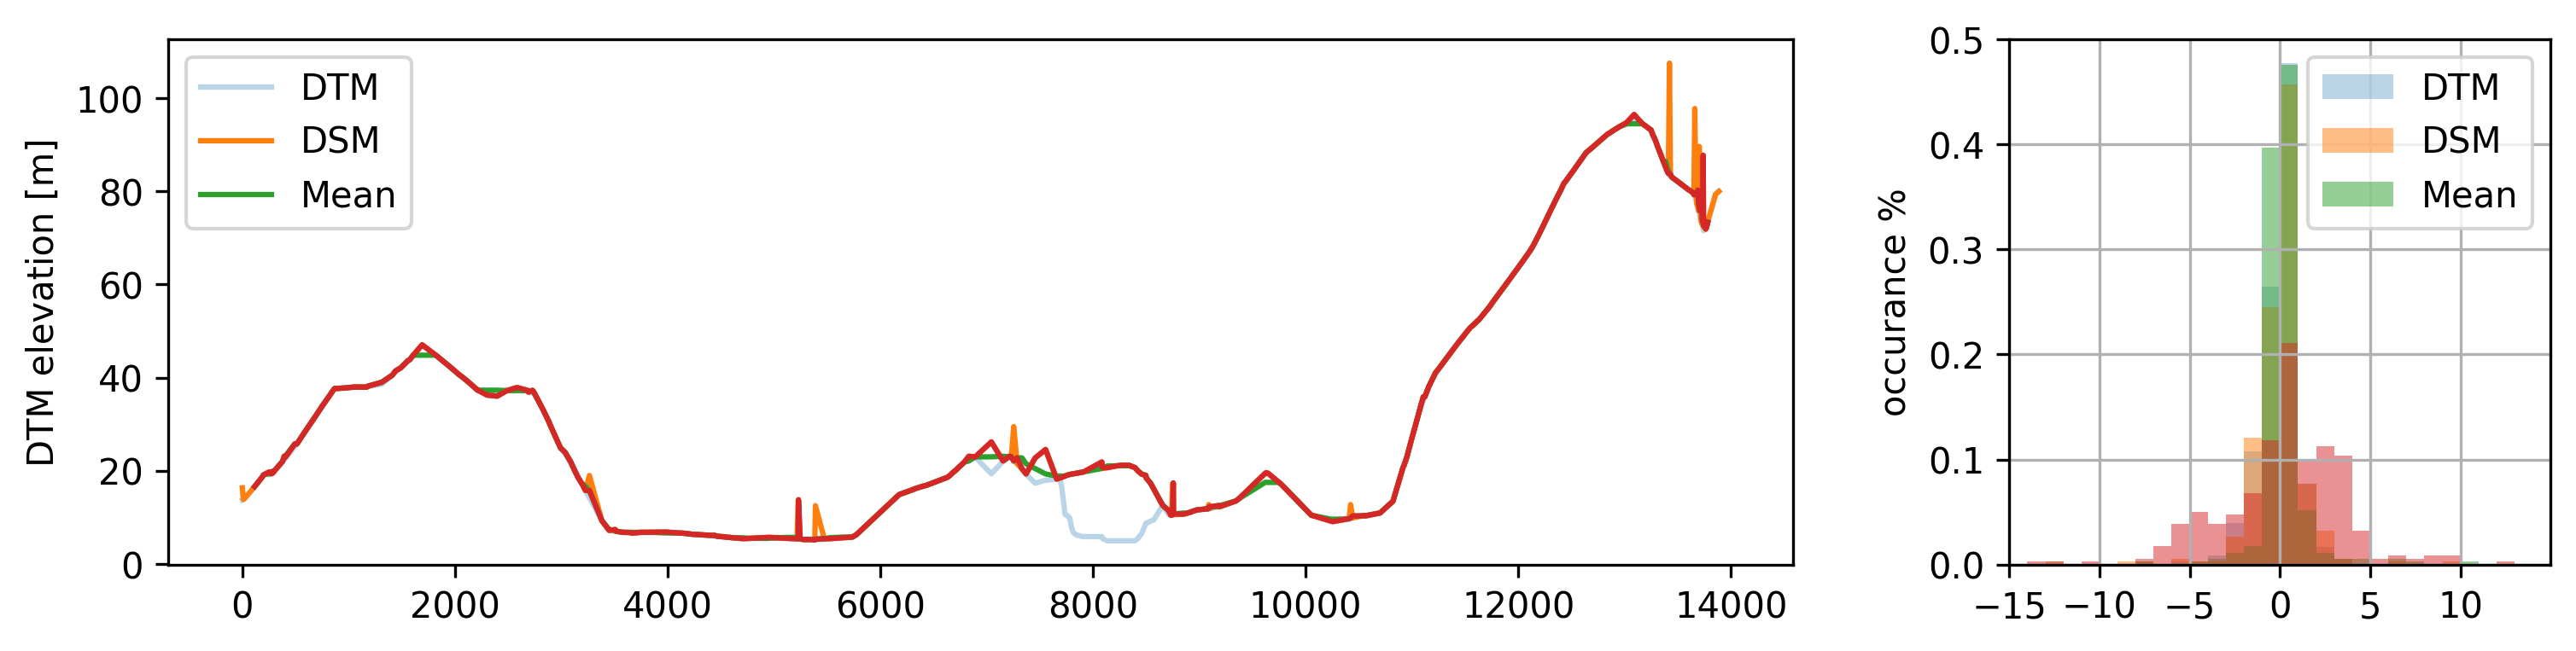

In [737]:
fig, ax = plt.subplots(1,2, figsize = (12, 2.666), dpi=300, gridspec_kw={'width_ratios': [3, 1]})
ax[0].plot(trip_shape['have_dist_traveled'], trip_shape['DTM_elev'], alpha=.3)
ax[0].plot(trip_shape['have_dist_traveled'], trip_shape['DSM_elev'], alpha=1)
ax[0].plot(trip_shape['have_dist_traveled'], (trip_shape['DSM_elev'].rolling(7).median()).shift(-3), alpha=1)
ax[0].plot(trip_shape['have_dist_traveled'], trip_shape['filtered_DSM_elevation'], alpha=1)

ax[0].set_ylabel("DTM elevation [m]")
ax[0].legend(['DTM', "DSM", "Mean"])


trip_shape['mean_grade'] = (((trip_shape['DSM_elev'].rolling(7).mean()).shift(-3)).diff()/trip_shape['shape_dist_traveled'].diff()*.3048*100)[:].apply(float)
ax[1].hist(trip_shape['DTM_base_grade'][1:], alpha=.3, density=True, bins=bins)
ax[1].hist(trip_shape['DSM_base_grade'][1:], alpha=.5, density=True, bins=bins)
ax[1].hist(trip_shape['mean_grade'][1:], alpha=.5, bins=bins, density=True)
ax[1].hist(trip_shape['filtered_DSM_elevation'].diff()[1:]/trip_shape['have_dx'][1:]*100, alpha=.5, bins=bins, density=True)
ax[1].set_ylabel("occurance %")
ax[1].legend(['DTM', "DSM", "Mean"])
ax[1].set_ylim(0,.5)
ax[1].set_xlim(-15,15)
ax[1].grid()
start, end = ax[1].get_xlim()
ax[1].xaxis.set_ticks(np.arange(start, end, 5))

In [651]:
trip_shape['roll_DSM_elev'] = (trip_shape['DSM_elev'].rolling(7).mean()).shift(-3)
trip_shape

,shape_dist_traveled,geometry,sequence,stop_id,arrival_time,departure_time,target_rest_time,target_total_time,DSM_elev,DTM_elev,...,have_dx,have_dist_traveled,smooth_DSM,smooth_DTM,DTM_base_grade,DSM_base_grade,DTM_smooth_grade,DSM_smooth_grade,mean_grade,roll_DSM_elev
0,0.0,POINT (-122.32906 47.59984),1,619.0,1900-01-01 17:45:00,1900-01-01 17:45:00,0.0,0.0,[53.658573],[45.01668],...,0.000000,0.000000,50.561285,43.427824,NaN,NaN,NaN,NaN,NaN,NaN
1,28.0,POINT (-122.32905 47.59992),2,NaN,NaT,NaT,NaN,NaN,[45.450157],[45.3186],...,0.009400,0.009400,49.255896,46.430354,0.328659,-8.935448,NaN,NaN,NaN,NaN
2,75.1,POINT (-122.32898 47.60004),3,NaN,NaT,NaT,NaN,NaN,[46.290016],[46.0755],...,0.013737,0.023137,50.113323,49.773580,0.489816,0.543501,NaN,NaN,NaN,NaN
3,379.6,POINT (-122.32900 47.60087),4,NaN,NaT,NaT,NaN,NaN,[54.507164],[54.403866],...,0.092507,0.115643,52.492265,53.226354,0.833657,0.822524,NaN,NaN,NaN,54.556299
4,566.4,POINT (-122.32942 47.60130),5,NaN,NaT,NaT,NaN,NaN,[59.930523],[59.679153],...,0.057311,0.172954,55.751419,56.557529,0.860764,0.884925,NaN,NaN,0.197431,55.766278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,45204.4,POINT (-122.40090 47.69432),349,NaN,NaT,NaT,NaN,NaN,[238.29947],[238.16827],...,0.005377,13.774230,238.087309,238.073606,2.833969,2.754376,4.604973,2.960696,5.209038,241.547869
349,45228.1,POINT (-122.40095 47.69439),350,NaN,NaT,NaT,NaN,NaN,[240.72012],[240.59698],...,0.007988,13.782218,241.418970,241.361267,3.123507,3.113145,4.863725,3.248368,4.909666,245.365424
350,45251.4,POINT (-122.40097 47.69445),351,NaN,NaT,NaT,NaN,NaN,[243.12799],[243.01492],...,0.007404,13.789622,246.730058,246.599867,3.163037,3.149863,6.387009,4.363356,NaN,NaN
351,45469.5,POINT (-122.40121 47.69502),352,NaN,NaT,NaT,NaN,NaN,[260.37662],[260.22318],...,0.065666,13.855288,254.398759,254.243404,2.404895,2.410537,0.852807,0.591117,NaN,NaN


In [31]:
benchmark_paths = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(benchmark_paths).to_crs(epsg = 4326)

benchmarks['ll_tuple'] = benchmarks['geometry'].apply(lambda x: (x.x, x.y))

dsm_benchmark_comparison = pd.DataFrame(query_elevation_benchmarks(benchmarks, reprojected_DSMs, "DSM")).T.sort_index()
dtm_benchmark_comparison = pd.DataFrame(query_elevation_benchmarks(benchmarks, reprojected_DTMs, "DTM")).T.sort_index()
# convert dsm and dtm elevations from feet to meters:
dsm_benchmark_comparison['DSM_Model_elevation'] = dsm_benchmark_comparison['DSM_Model_elevation']*.3048
dtm_benchmark_comparison['DTM_Model_elevation'] = dtm_benchmark_comparison['DTM_Model_elevation']*.3048
benchmark_comparison = pd.merge(dsm_benchmark_comparison, dtm_benchmark_comparison, left_index=True, right_index=True)

In [32]:
import scipy.optimize
def fit_linear_data(xdata, ydata):
    def linfunc(x, m, b):
        y=m*x+b
        return y
    parameters, covariance = scipy.optimize.curve_fit(linfunc, xdata, ydata)
    pred_y = linfunc(xdata, parameters[0], parameters[1])
    squared_res = ((pred_y-ydata)**2).sum()
    total_squares = ((ydata-ydata.mean())**2).sum()
    MSE = ((pred_y-ydata)**2).mean()
    r_squared = 1-(squared_res/total_squares)
    return parameters, MSE, r_squared, pred_y

y=0.9966640993486034x+1.465358749801565
mean_squared_error: 133.07561165374258
r_squared: 0.952486475920009


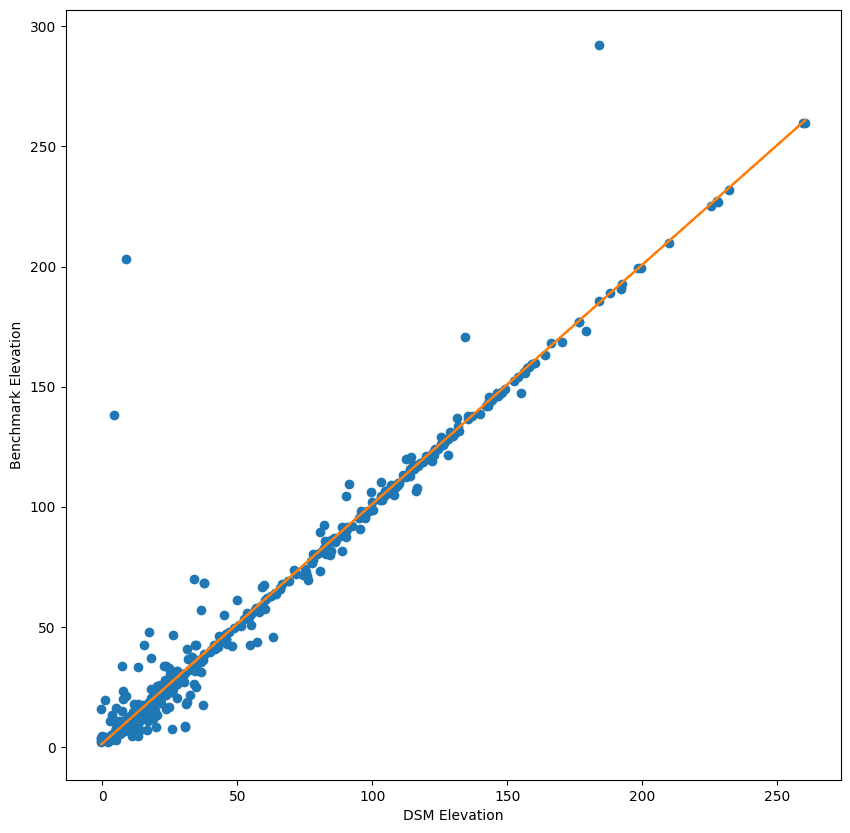

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dtm_elev = dtm_benchmark_comparison['DTM_Model_elevation'].apply(float)
true_dtm = dtm_benchmark_comparison['True_elevation'].apply(float)
ax.scatter(dtm_elev, true_dtm)
ax.set_xlabel("DSM Elevation")
ax.set_ylabel("Benchmark Elevation")
params, mse, r2, pred_elev = fit_linear_data(dtm_elev, true_dtm)
ax.plot(dtm_elev, pred_elev, c="tab:orange")
print("y={}x+{}".format(params[0], params[1]))
print("mean_squared_error: {}".format(mse))
print("r_squared: {}".format(r2))

y=0.9719174268681845x+-0.7666021447101472
mean_squared_error: 149.03833070441777
r_squared: 0.948345747168738


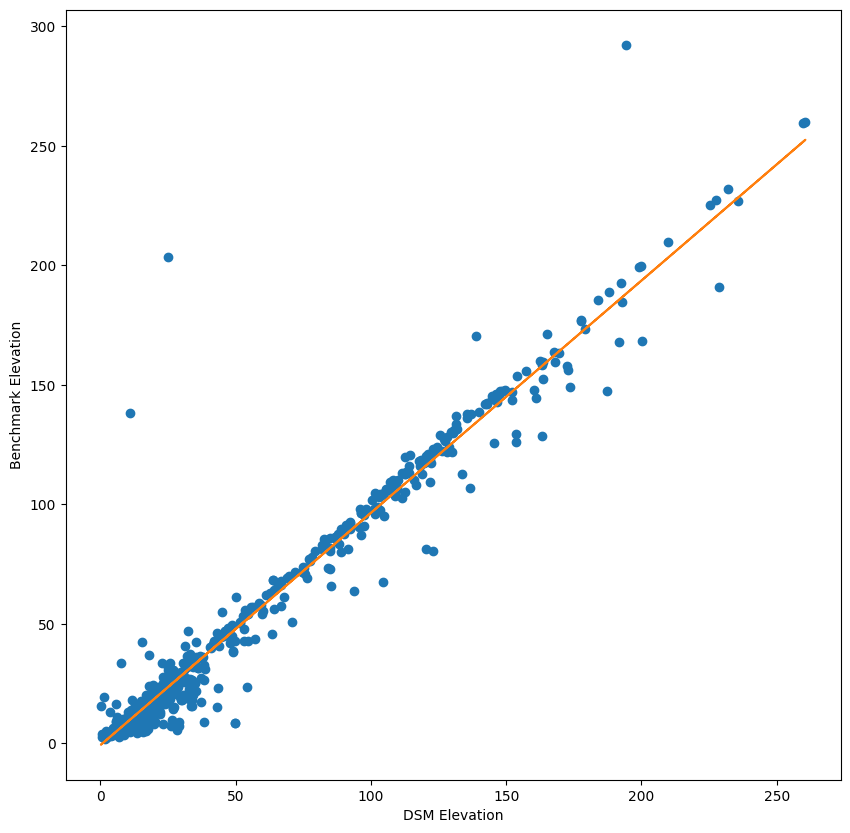

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dsm_elev = dsm_benchmark_comparison['DSM_Model_elevation'].apply(float)
true_dsm = dsm_benchmark_comparison['True_elevation'].apply(float)
ax.scatter(dsm_elev, true_dsm)
ax.set_xlabel("DSM Elevation")
ax.set_ylabel("Benchmark Elevation")
params, mse, r2, pred_elev = fit_linear_data(dsm_elev, true_dsm)
ax.plot(dsm_elev, pred_elev, c="tab:orange")
print("y={}x+{}".format(params[0], params[1]))
print("mean_squared_error: {}".format(mse))
print("r_squared: {}".format(r2))

Text(0, 0.5, 'DSM Model %error')

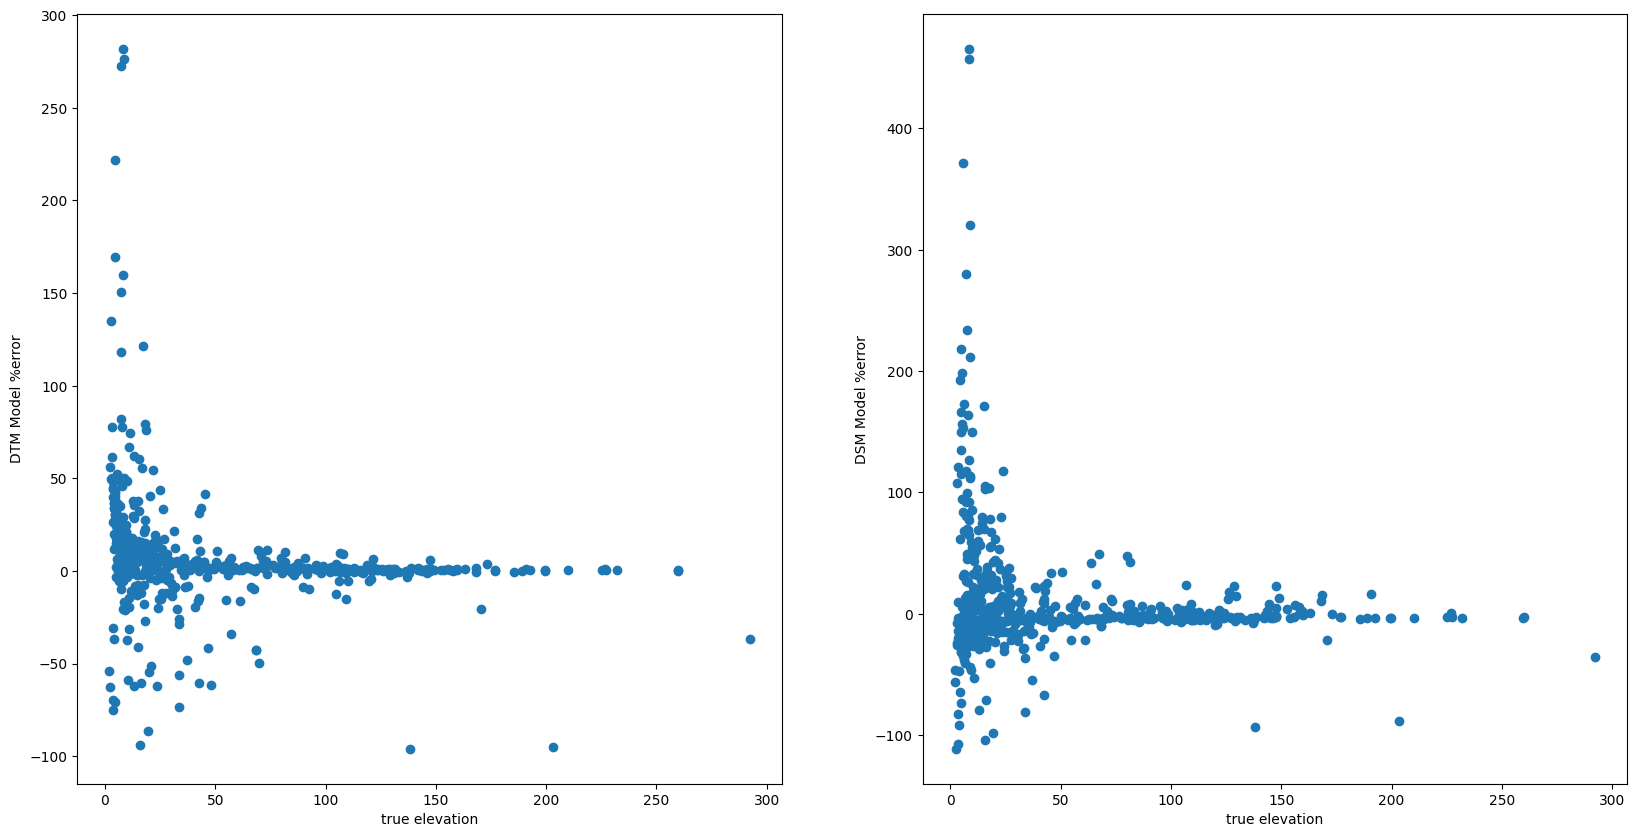

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
merged_dtm = benchmark_comparison["DTM_Model_elevation"].apply(float)
merged_dsm = benchmark_comparison["DSM_Model_elevation"].apply(float)
merged_true = benchmark_comparison['True_elevation_y'].apply(float)

merged_dtm_prediction = 0.9966640993486034*merged_dtm+1.465358749801565
merged_dsm_prediction = 0.9719174268681845*merged_dsm-0.7666021447101472

dtm_error = (merged_dtm_prediction - merged_true)/merged_true * 100
dsm_error = (merged_dsm_prediction - merged_true)/merged_true * 100
ax[0].scatter(merged_true, (dtm_error))
ax[1].scatter(merged_true, (dsm_error))
ax[0].set_xlabel("true elevation")
ax[0].set_ylabel("DTM Model %error")
ax[1].set_xlabel("true elevation")
ax[1].set_ylabel("DSM Model %error")

DSM:
	 mean: 2.1621974833312514, med: 0.357866549682619, std: 12.358910814635452
DTM:
	 mean: -1.3107732048833918, med: -0.03914042663573625, std: 11.54630296604193


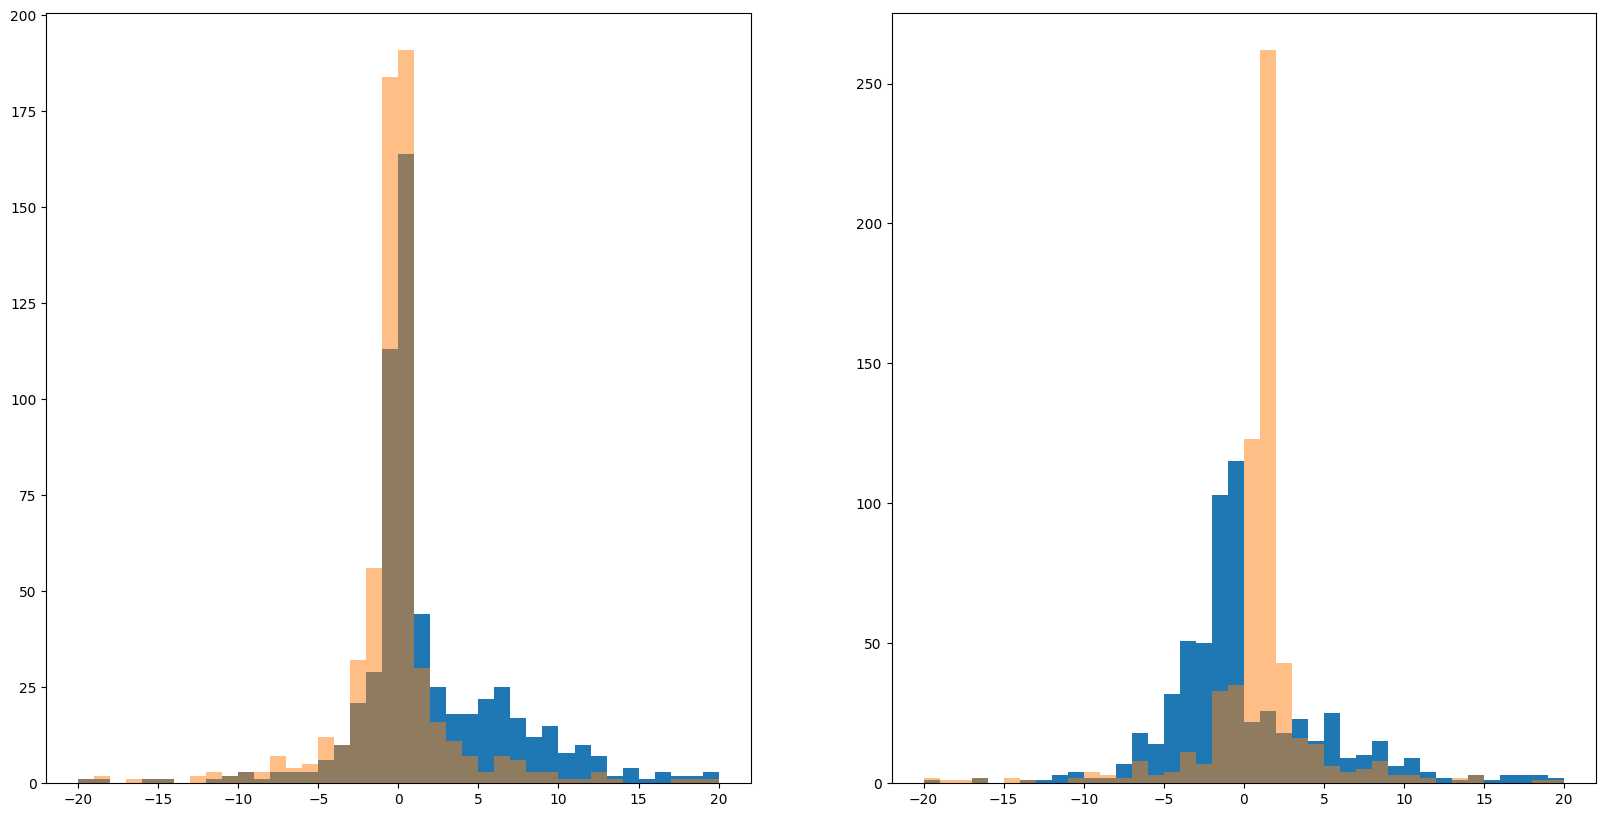

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
bins = [-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

dsm_diff = merged_dsm-merged_true
dsm_mean_offset = dsm_diff.mean()
dsm_std_offset = dsm_diff.std()
dsm_med_offset = dsm_diff.median()

dtm_diff = merged_dtm-merged_true
dtm_mean_offset = dtm_diff.mean()
dtm_std_offset = dtm_diff.std()
dtm_med_offset = dtm_diff.median()

ax[0].hist(dsm_diff, bins=bins, alpha=1)
ax[0].hist(dtm_diff, bins=bins, alpha=.5)
ax[1].hist(merged_dsm_prediction-merged_true, bins=bins, alpha=1)
ax[1].hist(merged_dtm_prediction-merged_true, bins=bins, alpha=.5)

# orange: digital terrain model (last ping back)
# blue: digital surface model (first ping back)

# positive means that the prediciton is higher than the true value
# negative means the prediciton is lower than the true value

#Both DTM and DSM are typically within +/-1 meter of the true elevation
#linearized model projects that the DTM overapproximates by around 3 meters
#linearized model projects the DSM is typically under the benchmarked value, these are both counter-intuitive.
# When DTM suddently drops off, use DSM. When DSM is suddenly large, use DTM. 
print("DSM:")
print("\t mean: {}, med: {}, std: {}".format(dsm_mean_offset, dsm_med_offset, dsm_std_offset))
print("DTM:")
print("\t mean: {}, med: {}, std: {}".format(dtm_mean_offset, dtm_med_offset, dtm_std_offset))

In [37]:
import scipy.optimize
def fit_double_data(x1data, x2data, ydata):
    def bivarfunc(x, m1, m2, b):
        y=m1*x[0] + m2+x[1] +b
        return y
    parameters, covariance = scipy.optimize.curve_fit(bivarfunc, [x1data, x2data], ydata)
    print(parameters)
    pred_y = bivarfunc([x1data, x2data], parameters[0], parameters[1], parameters[2])
    squared_res = ((pred_y-ydata)**2).sum()
    total_squares = ((ydata-ydata.mean())**2).sum()
    MSE = ((pred_y-ydata)**2).mean()
    r_squared = 1-(squared_res/total_squares)
    return parameters, MSE, r_squared, pred_y

[-1.77450221e-02  4.91613839e+03 -4.91747828e+03]
y=-0.017745022115339903*x1+4916.138388281638*x2+-4917.478281716881
mean_squared_error: 151.65456837060643
r_squared: 0.9458530162170794


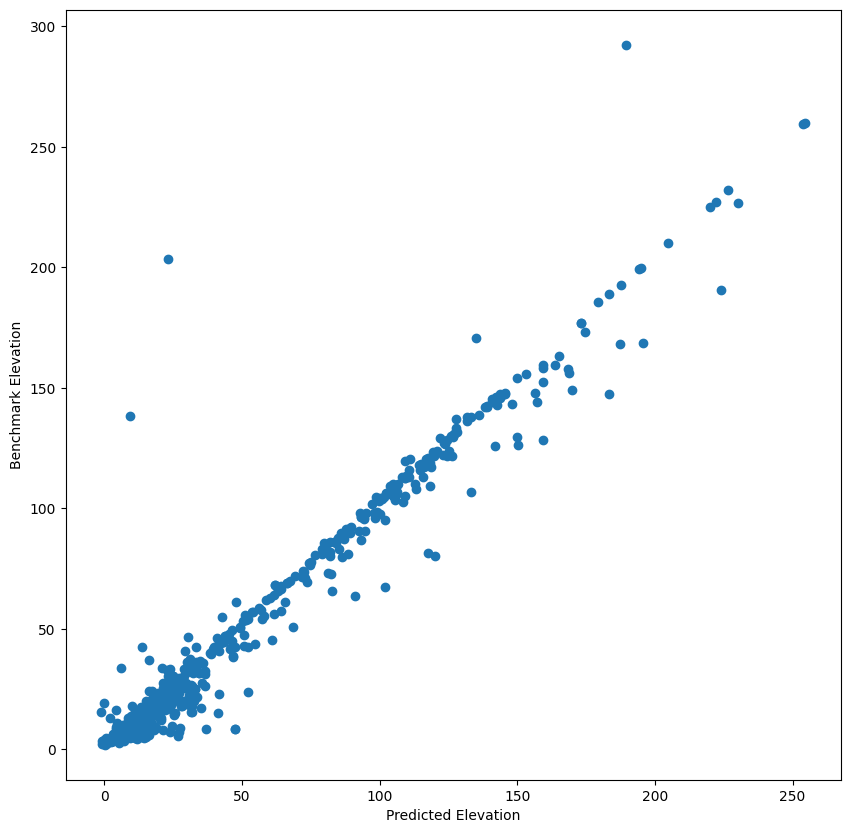

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.set_xlabel("Predicted Elevation")
ax.set_ylabel("Benchmark Elevation")
params, mse, r2, pred_elev = fit_double_data(merged_dtm, merged_dsm, merged_true)
ax.scatter(pred_elev, true_dtm)
print("y={}*x1+{}*x2+{}".format(params[0], params[1], params[2]))
print("mean_squared_error: {}".format(mse))
print("r_squared: {}".format(r2))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 392.,  29.,
         23.,  13.,  19.,  23.,  16.,  14.,  18.,  12.,  11.,   7.,  10.,
          2.,   2.,   2.,   4.,   5.,   2.,   3.]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <BarContainer object of 40 artists>)

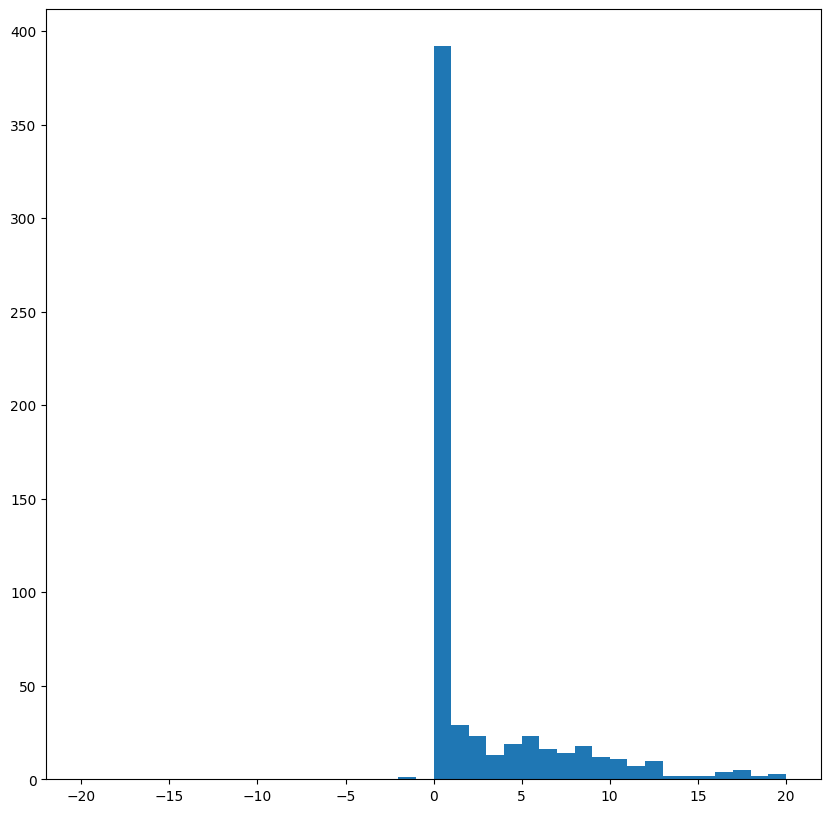

In [39]:
type_diff =(merged_dsm - merged_dtm)
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(type_diff, bins=bins)

In [40]:
import RouteMap as rm
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))
route_shape = gpd.read_file(routefiles[0])
# Get the route geometry 
route_sampled = route_shape[::].reset_index(drop=True)
route_geometry = route_sampled['geometry']
route_elevation = route_sampled['Z']
route_map = rm.RouteMap(route_geometry, route_elevation)
old_elev = route_map.get_elevation()
old_smooth_elev = route_map.smooth_elevation()
# why cant i just append anymore, pandas? this is dumb.
old_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
old_raw_grades = route_map.get_grade()
old_smooth_grades = (route_map.set_elevation(old_smooth_elev)).get_grade()


In [97]:
import geopy.distance

In [98]:
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

In [124]:
def haversine_2(x1, y1, x2, y2):
    lat1=np.radians(x1)
    lon1=np.radians(y1)
    lat2=np.radians(x2)
    lon2=np.radians(y2)
    R = 6373.0
    dlon=lon2-lon1
    dlat=lat2-lat1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    
    return distance

In [125]:
haversine_2(47.683053, -122.398474, 47.675884, -122.398378)

0.797439082597375

In [138]:
diff

0      0.000000
4      0.056914
8      0.007506
12     0.070614
16     0.006869
         ...   
500    0.006256
504    0.009771
508    0.007396
512    0.000246
516    0.003340
Length: 130, dtype: float64

In [140]:
diff

0      0.000000
1      0.008545
2      0.014372
3      0.092853
4      0.056914
         ...   
512    0.000246
513    0.003970
514    0.004608
515    0.003086
516    0.003340
Length: 517, dtype: float64

In [188]:
rtg = gpd.GeoSeries(rt22elev_DSM['ll'])

In [ ]:
segment_list[49]

0    POINT (-122.39832 47.66954)
1    POINT (-122.39832 47.66977)
dtype: geometry

In [281]:
segment_list[48]

0    POINT (-122.39832 47.66862)
1    POINT (-122.39832 47.66947)
2    POINT (-122.39832 47.66954)
dtype: geometry

In [282]:
segment_list[47]

0    POINT (-122.39832 47.66862)
1    POINT (-122.39791 47.66863)
2    POINT (-122.39564 47.66864)
3    POINT (-122.39507 47.66865)
4    POINT (-122.39477 47.66867)
5    POINT (-122.39453 47.66868)
6    POINT (-122.39437 47.66868)
7    POINT (-122.39420 47.66866)
dtype: geometry

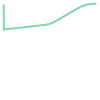

In [290]:
shapely.LineString( [[a.x, a.y] for a in segment_list[46].values])

/tmp/ipykernel_7087/2275638165.py:14: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ones.plot(color='orange', ax=ax, zorder=25, markersize=.2) #empty
/tmp/ipykernel_7087/2275638165.py:15: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  twos.plot(color='yellow', ax=ax, zorder=25, markersize=.2)
/tmp/ipykernel_7087/2275638165.py:16: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  threes.plot(color='lime', ax=ax, zorder=25, markersize=.2)
/tmp/ipykernel_7087/2275638165.py:17: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  fours.plot(color='green', ax=ax, zorder=25, markersize=.2)
/tmp/ipykernel_7087/2275638165.py:18: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  fives.plot(color='tab:blue', ax=ax, zorder=25, markersize=.2)
/tmp/ipykernel_7087/

<Axes: >

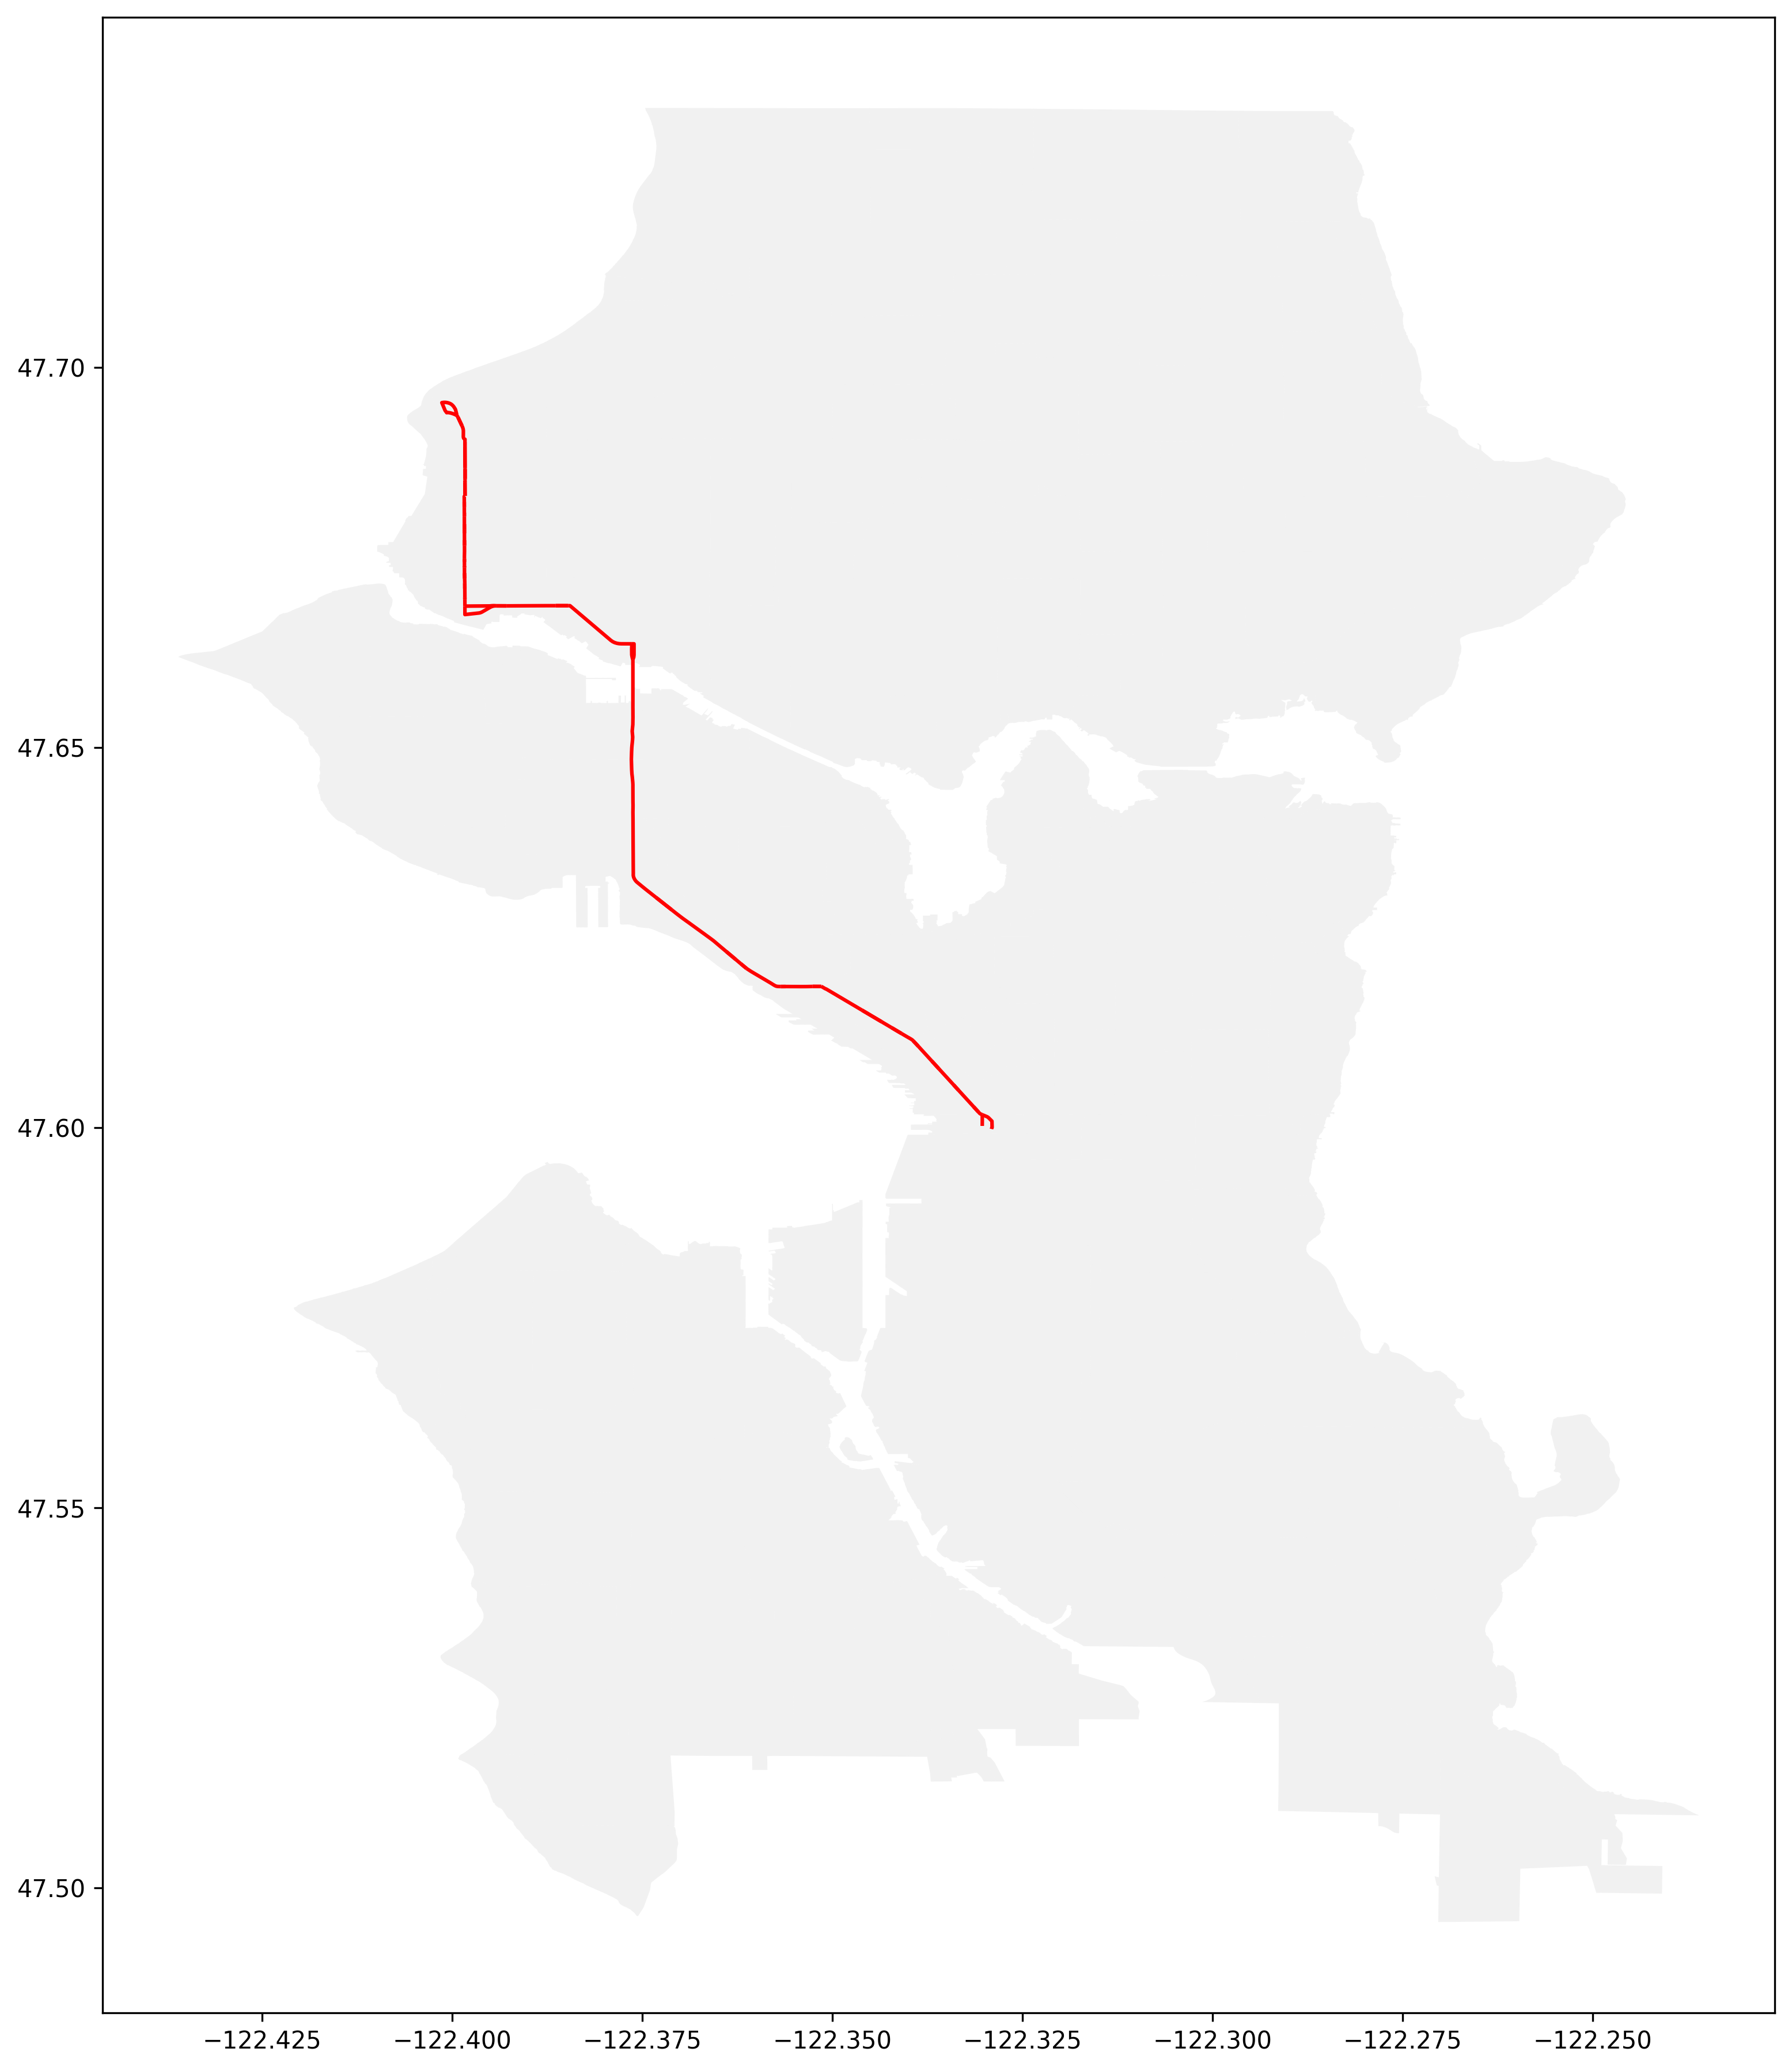

In [342]:
fig, ax = plt.subplots(1, figsize = (15, 15), dpi=300)



seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]


seattle.plot(color='#BDBDBD', ax=ax, zorder = 20, alpha = .2)
#rtg.plot(color="lime", ax=ax, zorder=30)
nones.plot(color='red', ax=ax, zorder=25, markersize=.2) # empty
ones.plot(color='orange', ax=ax, zorder=25, markersize=.2) #empty
twos.plot(color='yellow', ax=ax, zorder=25, markersize=.2)
threes.plot(color='lime', ax=ax, zorder=25, markersize=.2)
fours.plot(color='green', ax=ax, zorder=25, markersize=.2)
fives.plot(color='tab:blue', ax=ax, zorder=25, markersize=.2)
sixes.plot(color='cyan', ax=ax, zorder=25, markersize=.2)
sevens.plot(color='violet', ax=ax, zorder=25, markersize=.2)#empty
eights.plot(color='brown', ax=ax, zorder=25, markersize=.2) #empty


#ax.set_xlim(-122.4, -122.375)
#ax.set_ylim(47.65, 47.675)

In [173]:
1/np.log(y)

/tmp/ipykernel_7087/3208251566.py:1: RuntimeWarning: divide by zero encountered in divide
  1/np.log(y)


array([       inf, 1.44269504, 0.91023923, 0.72134752, 0.62133493,
       0.55811063, 0.51389834, 0.48089835])

Text(0, 0.5, 'fractional distribution')

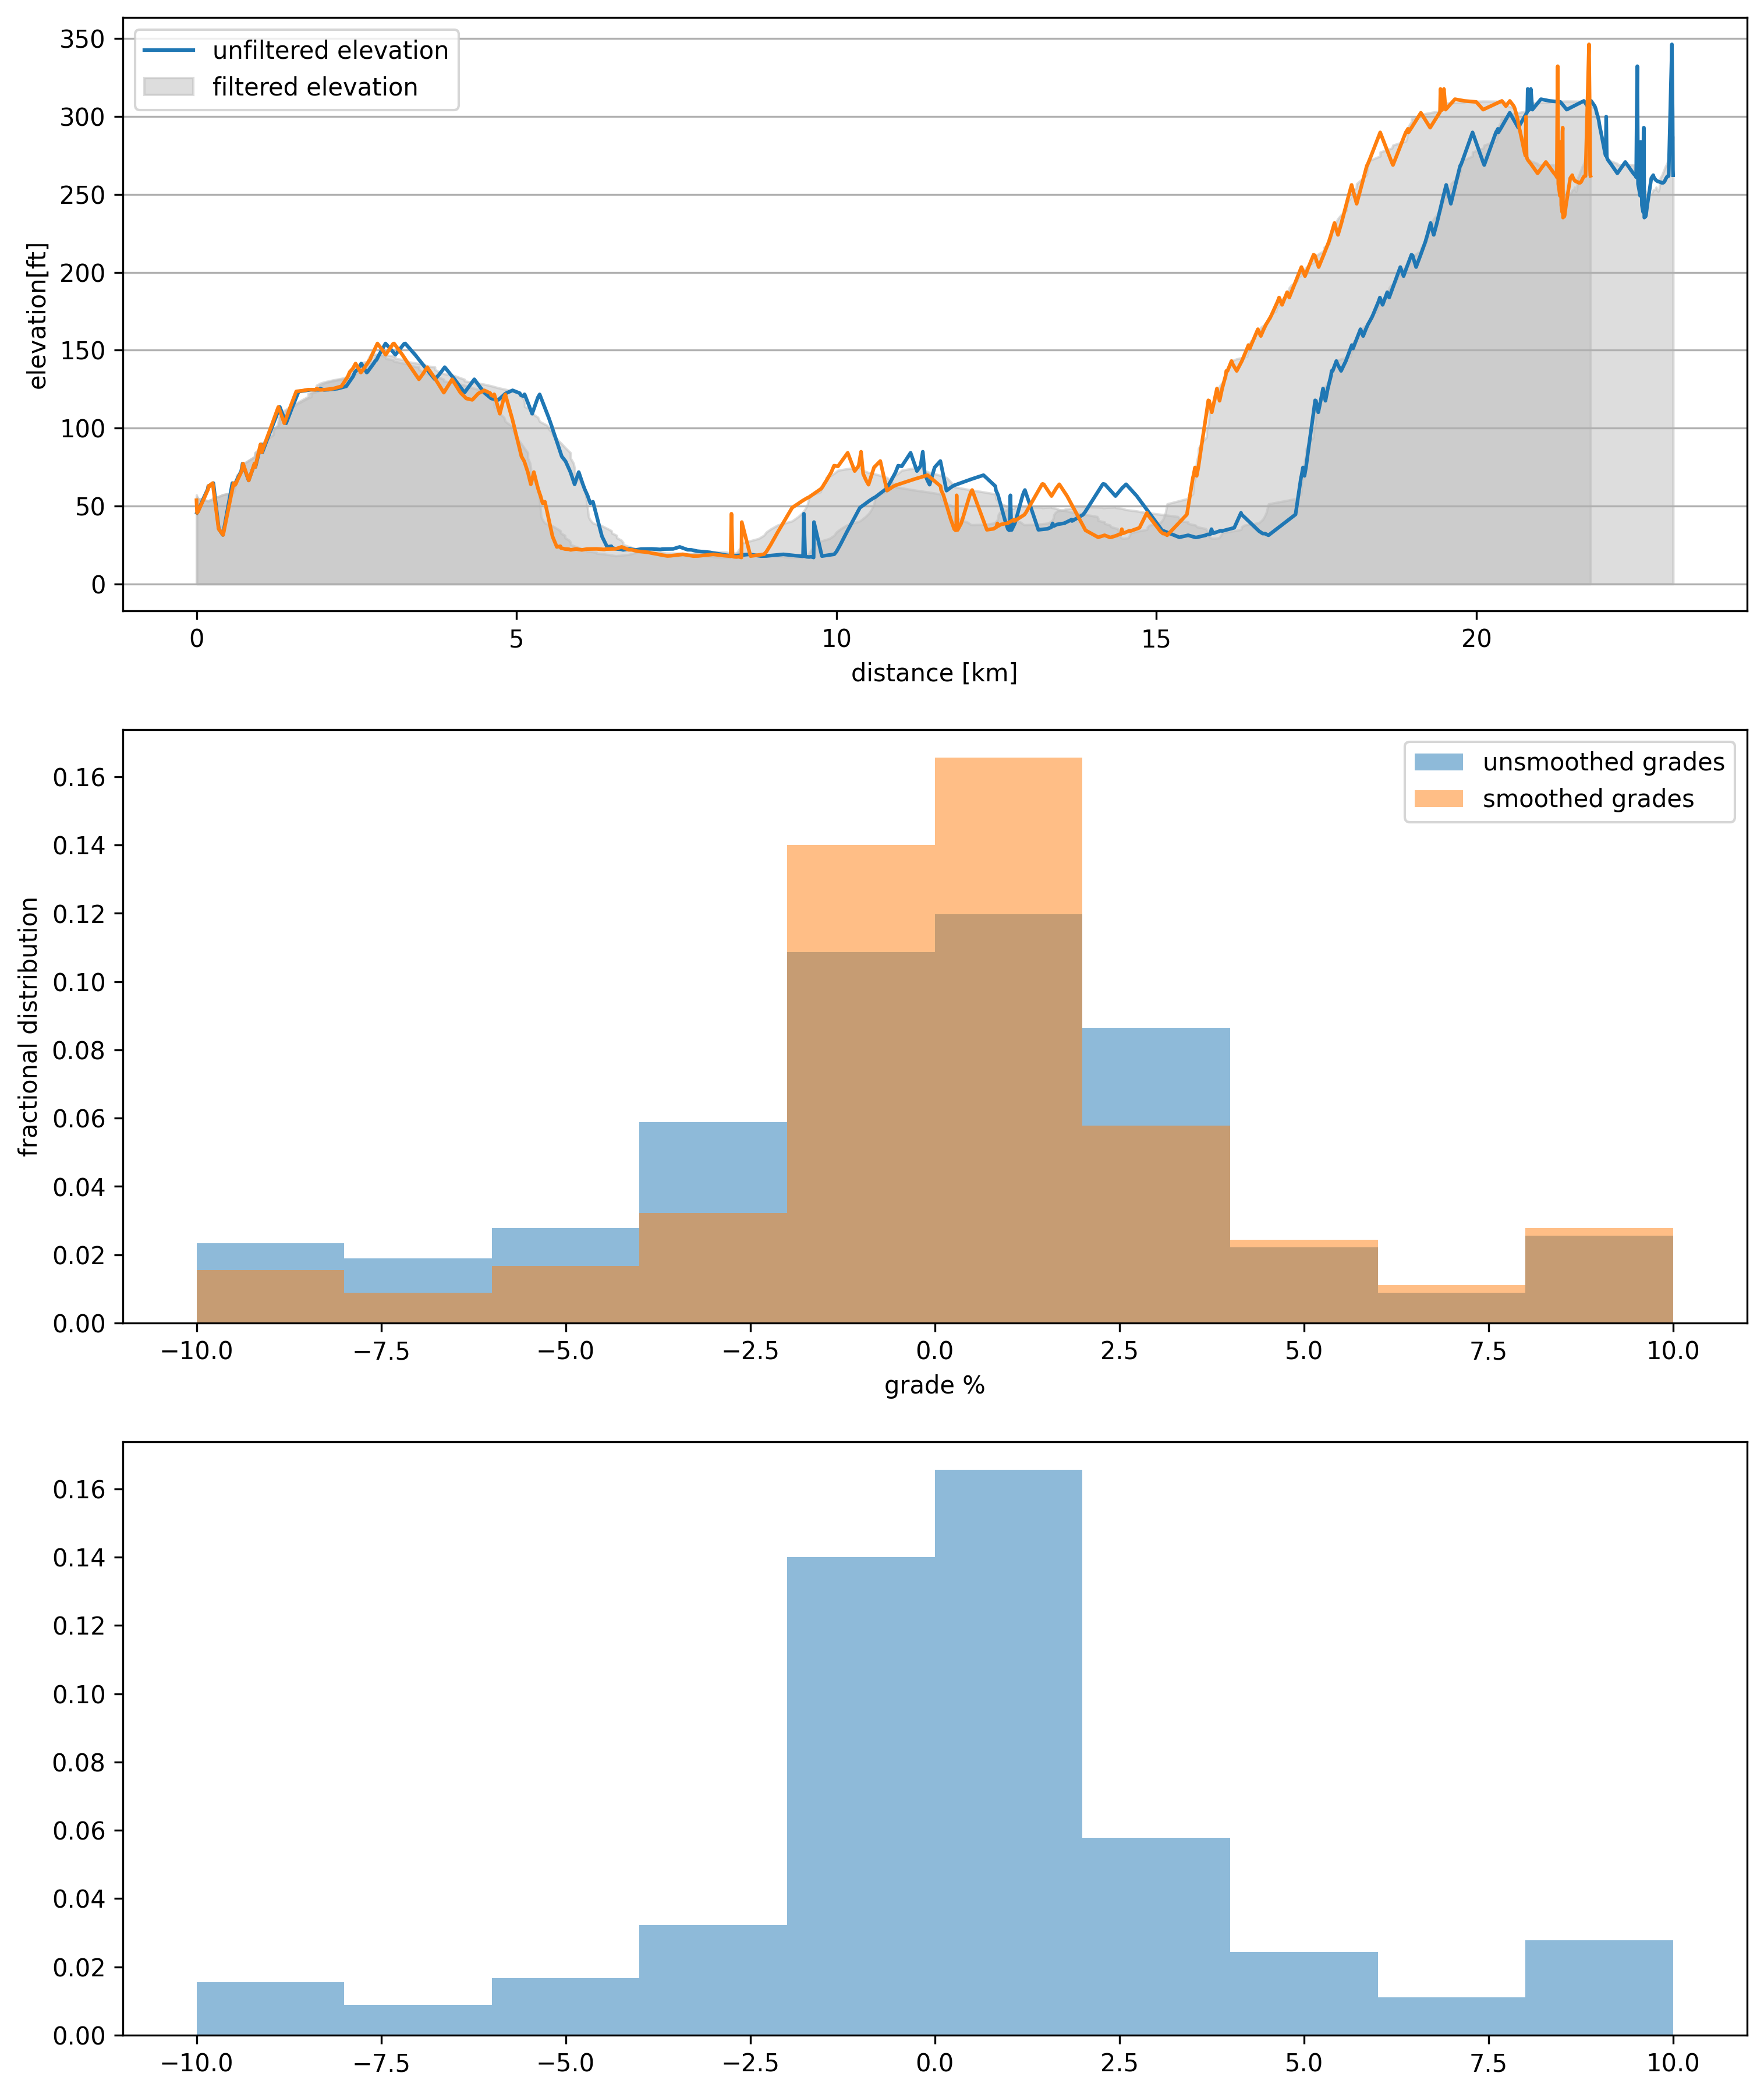

In [180]:
import RouteMap as rm
route_ll = (geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
data_dict = {}

for path in list(reprojected_DSMs):
        with rasterio.open(path) as img:
            route_DSM = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered_benchmarks = route_DSM[route_DSM.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            #print(filtered_benchmarks)
            for index in filtered_benchmarks.index:
                data_dict[index] = {'ll':route_ll[index], 'elev':filtered_benchmarks[index]}
rt22elev_DSM = pd.DataFrame(data_dict).T.sort_index()
rt22elev_DSM['elev'] = rt22elev_DSM['elev'].apply(float)
rt22elev_DSM['ll'] = rt22elev_DSM['ll'].apply(shapely.Point)

route_map = rm.RouteMap(rt22elev_DSM['ll'], rt22elev_DSM['elev'])
raw_DSM_elev = route_map.get_elevation()
smooth_DSM_elev = route_map.smooth_elevation()
DSM_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
raw_grades = route_map.get_grade()
smooth_grades = (route_map.set_elevation(smooth_DSM_elev)).get_grade()


rt22elev_DSM['lln'] = rt22elev_DSM['ll'].shift(1)
rt22elev_DSM.loc[0, 'lln'] = rt22elev_DSM['ll'][0]
    
diff = rt22elev_DSM[::].apply(lambda x: haversine_2(x.lln.y,x.lln.x,x.ll.y,x.ll.x), axis=1)
#diff = rt22elev_DSM[::4].apply(lambda x: shapely.distance(x.lln, x.ll)*61.13, axis=1)
new_DSM_dist = diff.cumsum()



fig, ax = plt.subplots(3,1, figsize = (12, 15), dpi=300)

ax[0].plot(DSM_dist, raw_DSM_elev*3280.84)
ax[0].fill_between(DSM_dist, smooth_DSM_elev*3280.84, color = '#BDBDBD', alpha=.5)
ax[0].plot(new_DSM_dist, raw_DSM_elev[::]*3280.84)
ax[0].fill_between(new_DSM_dist, smooth_DSM_elev[::]*3280.84, color = '#BDBDBD', alpha=.5)
ax[0].legend(['unfiltered elevation', 'filtered elevation'])
#ax[0].fill_between(old_dist, old_smooth_elev, color = '#000000', alpha=.5)
ax[0].grid(axis='y')
ax[1].hist(raw_grades, alpha=.5, density=True)
ax[1].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(smooth_grades, alpha=.5, density=True)
ax[0].set_xlabel('distance [km]')
ax[0].set_ylabel('elevation[ft]')

ax[1].legend(['unsmoothed grades', 'smoothed grades'])
ax[1].set_xlabel('grade %')
ax[1].set_ylabel('fractional distribution')
#ax[2].hist(old_smooth_grades, color="#000000", alpha=.5, density=True)

Text(0, 0.5, 'fractional distribution')

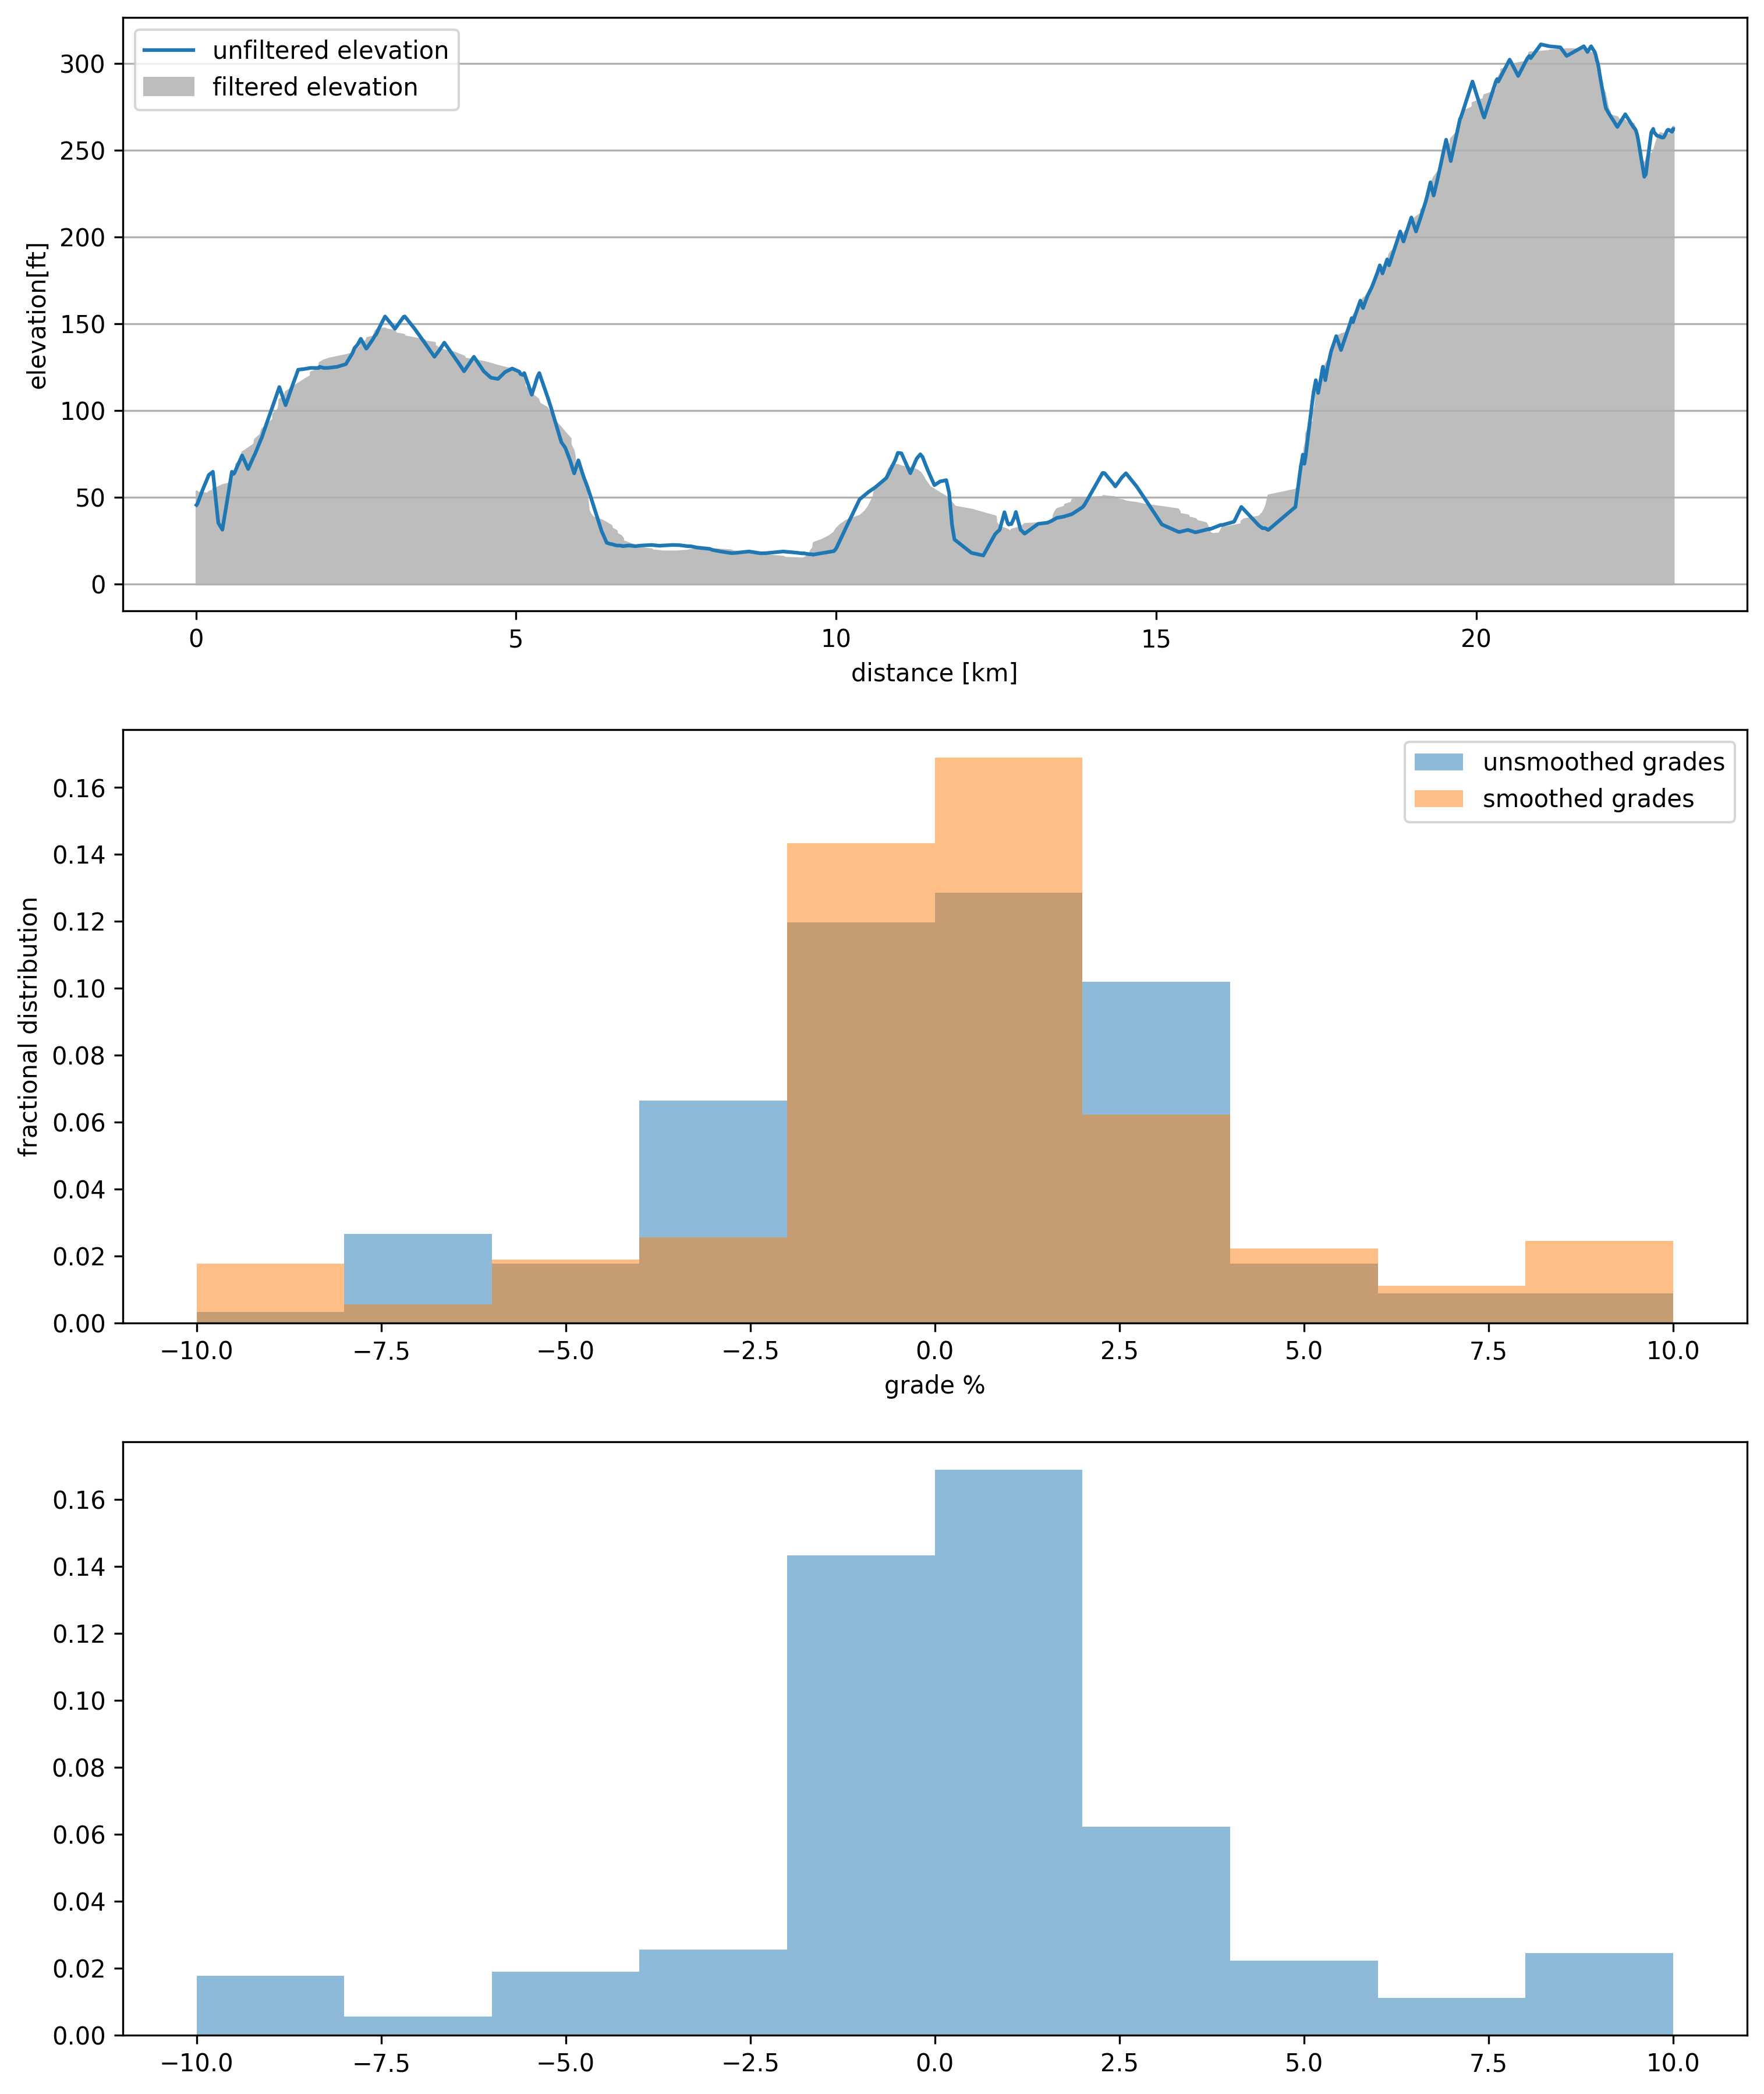

In [181]:
import RouteMap as rm
route_ll = (geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
data_dict = {}

for path in list(reprojected_DTMs):
        with rasterio.open(path) as img:
            route_DTM = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered_benchmarks = route_DTM[route_DTM.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            #print(filtered_benchmarks)
            for index in filtered_benchmarks.index:
                data_dict[index] = {'ll':route_ll[index], 'elev':filtered_benchmarks[index]}
rt22elev_DTM = pd.DataFrame(data_dict).T.sort_index()
rt22elev_DTM['elev'] = rt22elev_DTM['elev'].apply(float)
rt22elev_DTM['ll'] = rt22elev_DTM['ll'].apply(shapely.Point)

route_map = rm.RouteMap(rt22elev_DTM['ll'], rt22elev_DTM['elev'])
raw_DTM_elev = route_map.get_elevation()
smooth_DTM_elev = route_map.smooth_elevation()
DTM_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
raw_grades = route_map.get_grade()
smooth_grades = (route_map.set_elevation(smooth_DTM_elev)).get_grade()



fig, ax = plt.subplots(3,1, figsize = (12, 15), dpi=300)

ax[0].plot(DTM_dist, raw_DTM_elev*3280.84)
ax[0].fill_between(DTM_dist, smooth_DTM_elev*3280.84, color = '#BDBDBD')
ax[0].legend(['unfiltered elevation', 'filtered elevation'])
#ax[0].fill_between(old_dist, old_smooth_elev, color = '#000000', alpha=.5)
ax[0].grid(axis='y')
ax[1].hist(raw_grades, alpha=.5, density=True)
ax[1].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(smooth_grades, alpha=.5, density=True)
ax[0].set_xlabel('distance [km]')
ax[0].set_ylabel('elevation[ft]')

ax[1].legend(['unsmoothed grades', 'smoothed grades'])
ax[1].set_xlabel('grade %')
ax[1].set_ylabel('fractional distribution')
#ax[2].hist(old_smooth_grades, color="#000000", alpha=.5, density=True)

(array([0.02552228, 0.02464752, 0.04157662, 0.07188433, 0.07965421,
        0.09118041, 0.07157559, 0.04234846, 0.02428733, 0.02732325]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

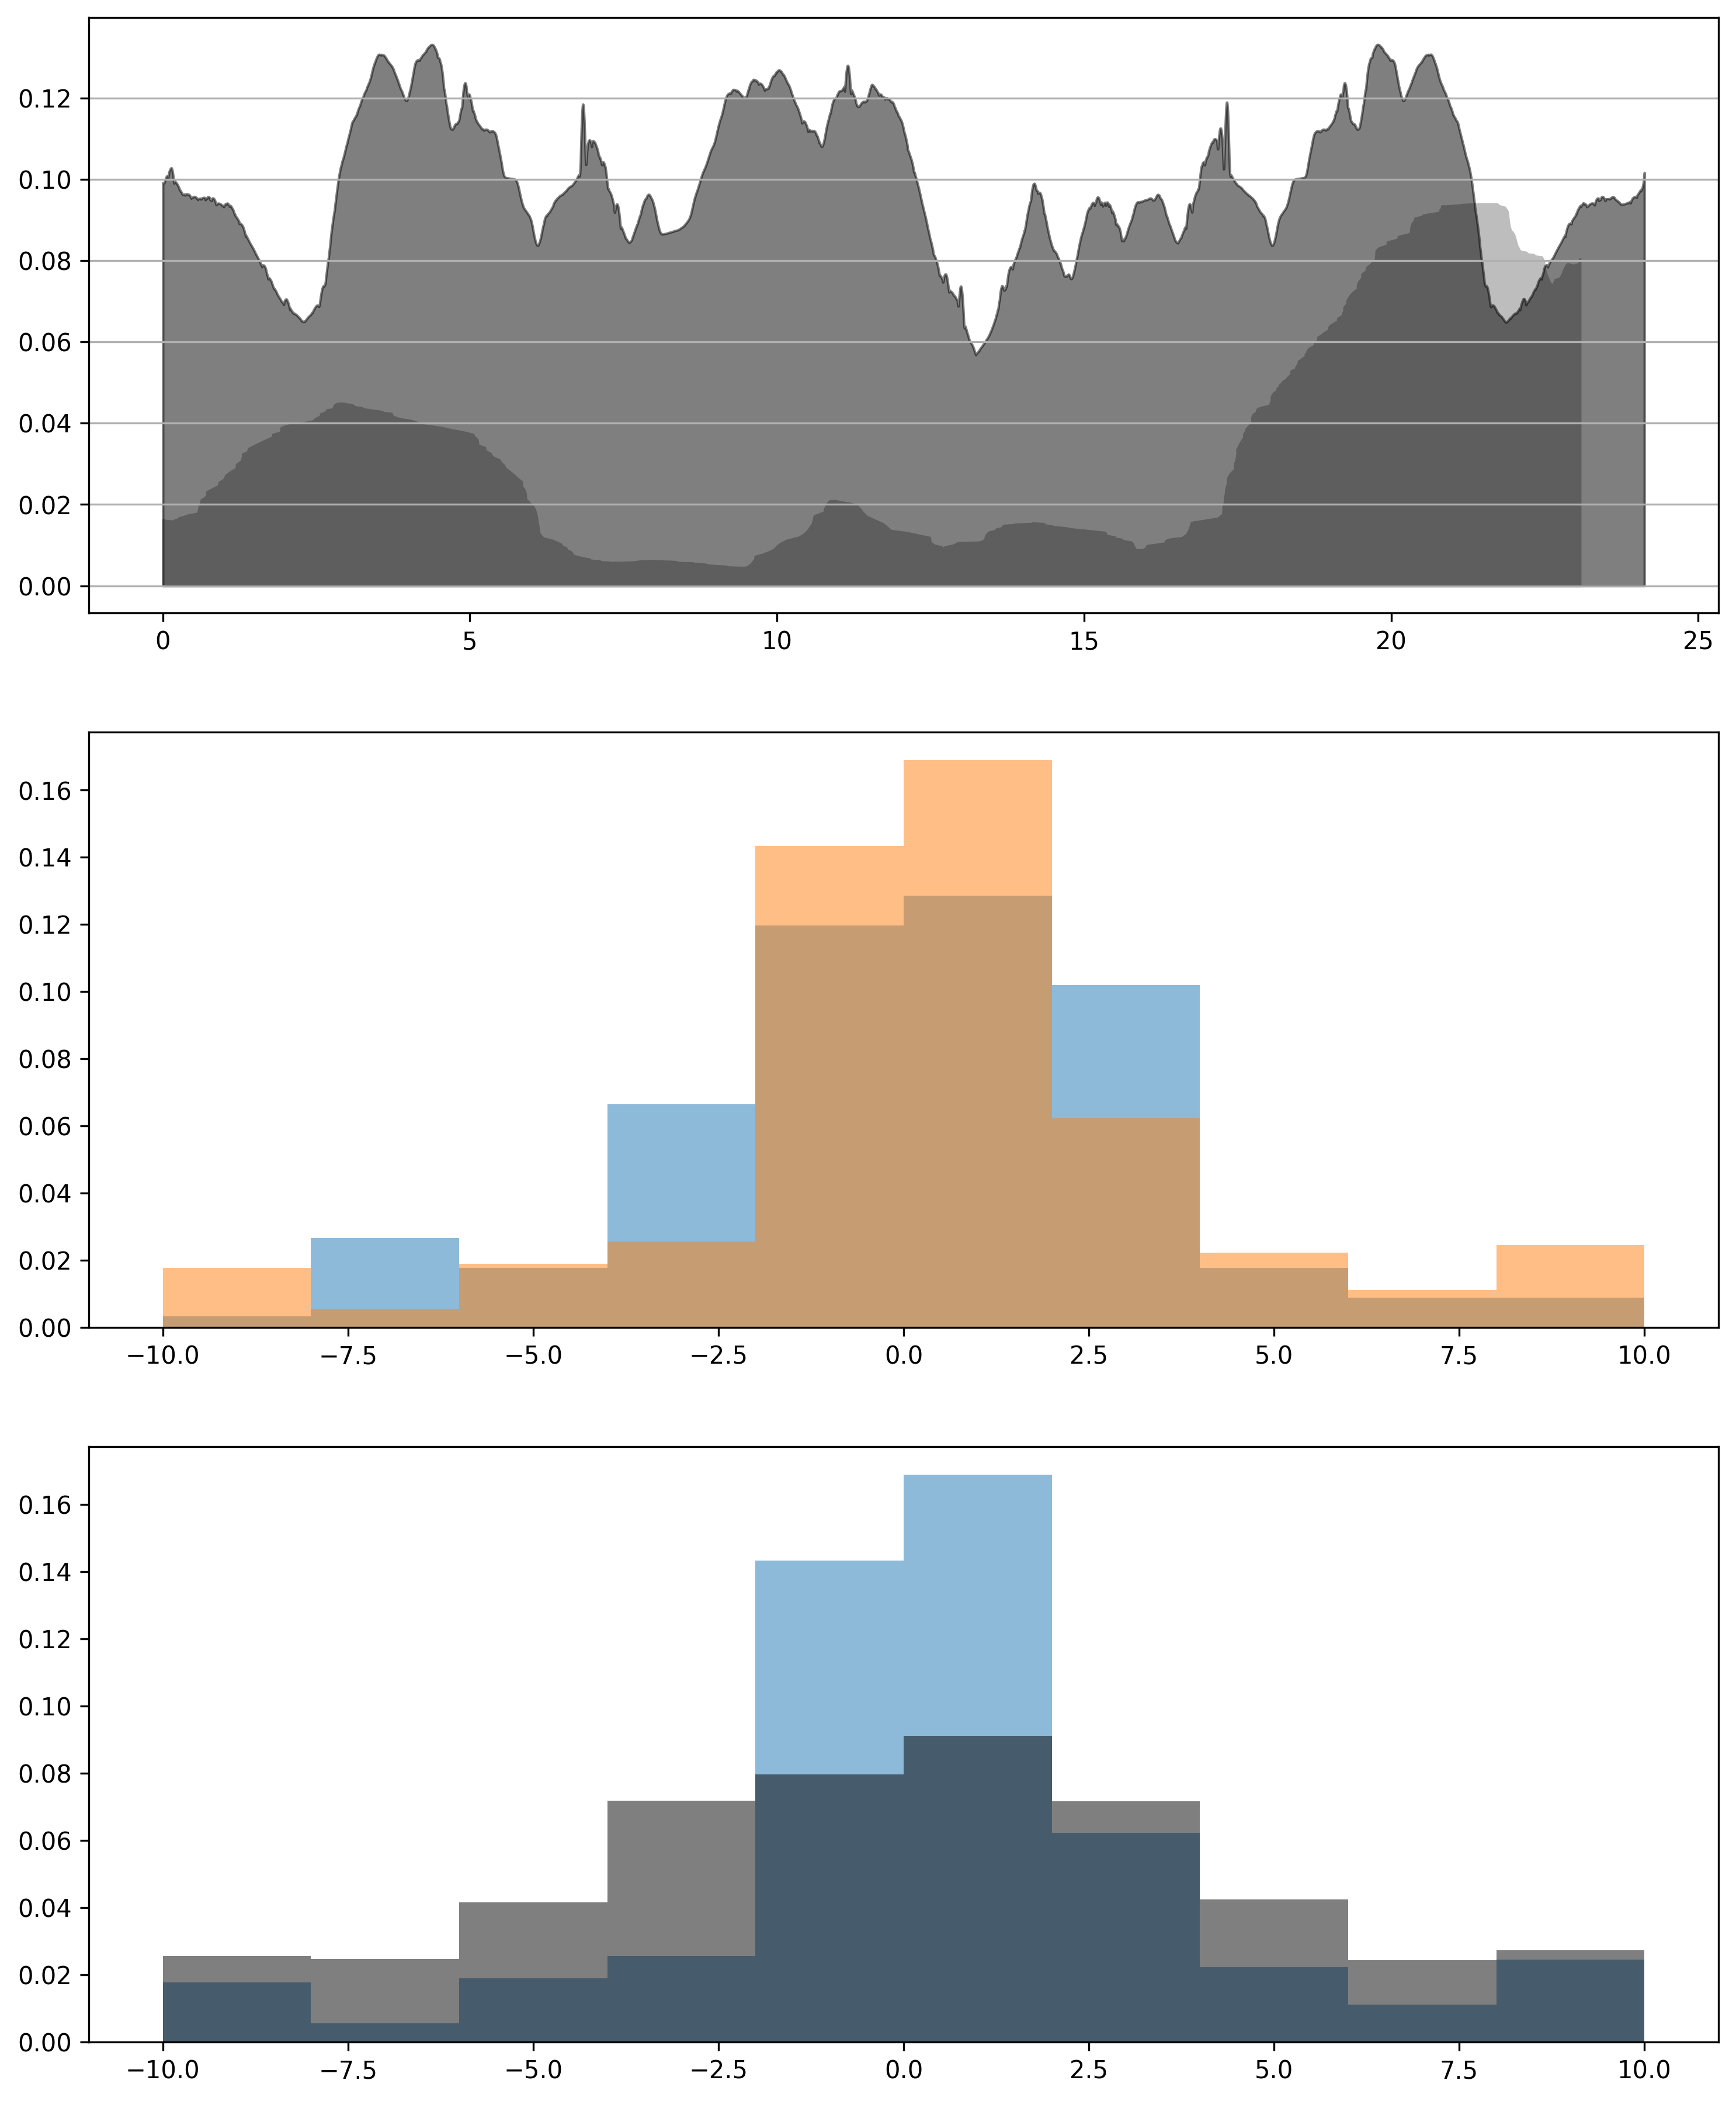

In [44]:
import RouteMap as rm
route_ll = (geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
data_dict = {}

for path in list(reprojected_DTMs):
        with rasterio.open(path) as img:
            route_DTM = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered_benchmarks = route_DTM[route_DTM.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            #print(filtered_benchmarks)
            for index in filtered_benchmarks.index:
                data_dict[index] = {'ll':route_ll[index], 'elev':filtered_benchmarks[index]}
rt22elev_DTM = pd.DataFrame(data_dict).T.sort_index()
rt22elev_DTM['elev'] = rt22elev_DTM['elev'].apply(float)
rt22elev_DTM['ll'] = rt22elev_DTM['ll'].apply(shapely.Point)

route_map = rm.RouteMap(rt22elev_DTM['ll'], rt22elev_DTM['elev'])
raw_DTM_elev = route_map.get_elevation()
smooth_DTM_elev = route_map.smooth_elevation()
DTM_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
raw_grades = route_map.get_grade()
smooth_grades = (route_map.set_elevation(smooth_DTM_elev)).get_grade()



fig, ax = plt.subplots(3,1, figsize = (12, 15), dpi=300)

#ax[0].plot(DTM_dist, raw_DTM_elev)
ax[0].fill_between(DTM_dist, smooth_DTM_elev, color = '#BDBDBD')
ax[0].fill_between(old_dist, old_smooth_elev, color = '#000000', alpha=.5)
ax[0].grid(axis='y')
ax[1].hist(raw_grades, alpha=.5, density=True)
ax[1].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(old_smooth_grades, color="#000000", alpha=.5, density=True)

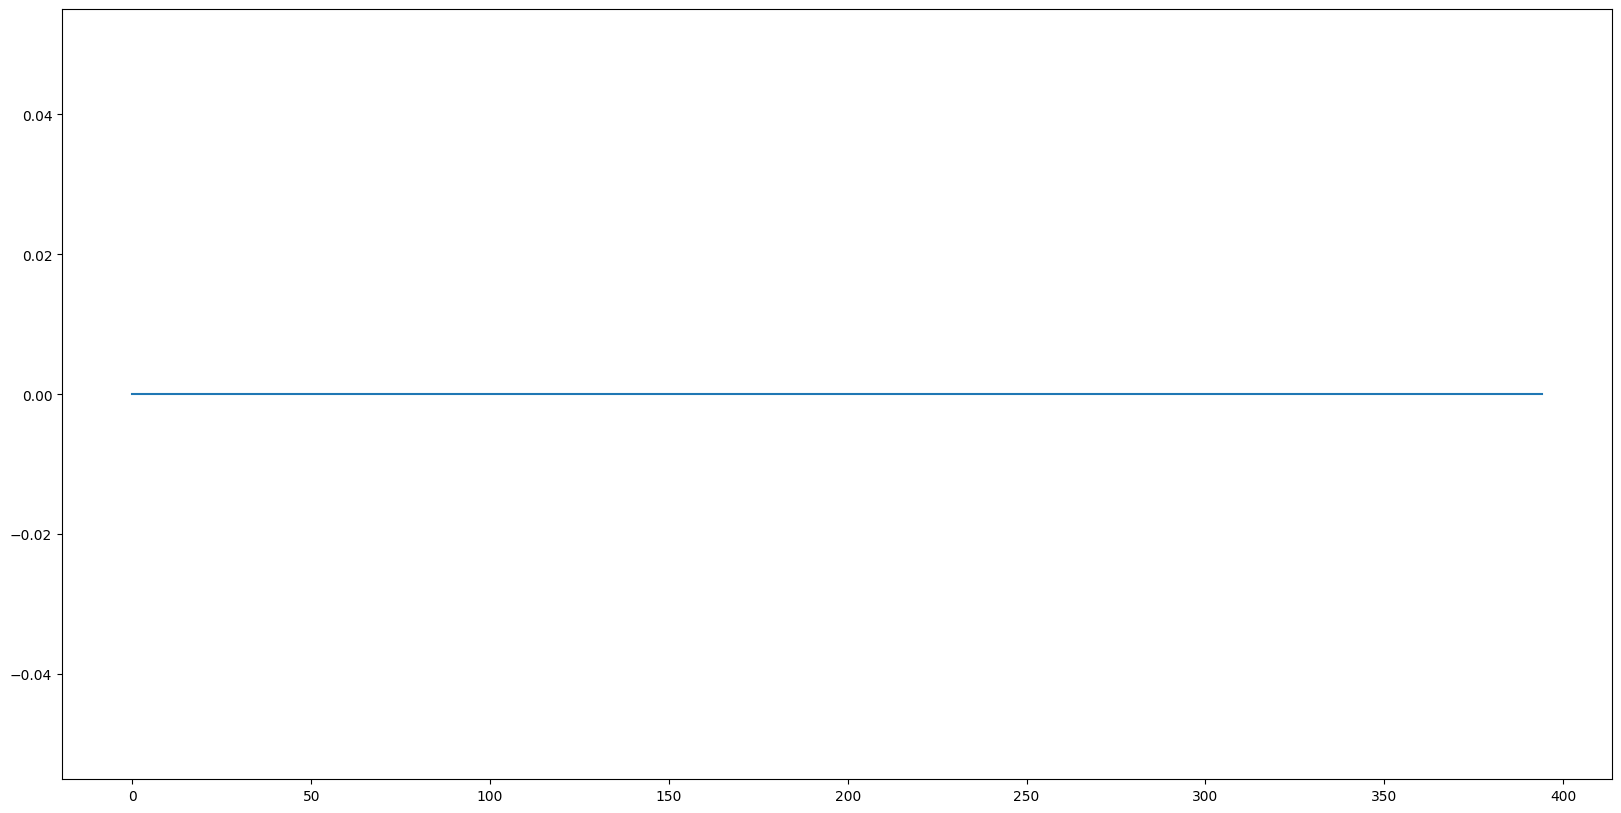

In [ ]:
benchmark_paths = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(benchmark_paths).to_crs(epsg = 4326)

benchmarks['ll_tuple'] = benchmarks['geometry'].apply(lambda x: (x.x, x.y))

def query_elevation_benchmarks(bench_data, model_path):
    all_benchmarks = {}
    for path in list(model_path):
        with rasterio.open(path) as img:
            bench_data['raster_elev'] = list(rasterio.sample.sample_gen(img, list(bench_data['ll_tuple']), masked=True))
            filtered_benchmarks = bench_data[bench_data['raster_elev'].apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]

            for row_2, col_2 in filtered_benchmarks.iterrows():
                data_dict = {'True_elevation':col_2['ELEVATION'], 'Model_elevation':col_2['raster_elev']}
                all_benchmarks[row_2] = data_dict
    return all_ben

In [116]:
import warnings
warnings.filterwarnings("ignore")
metadata_list = []
bounds = {'path':[], 'geometry':[]}
for raster_subset in rasterfiles[:]:
    with Image.open(raster_subset) as img:
        meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}
        pixel_scale = meta_dict['ModelPixelScaleTag'][:2]
        # upper left, lower left, upper right, lower right
        width_coords = meta_dict['ImageWidth'][0]*pixel_scale[0]
        height_coords = meta_dict['ImageLength'][0]*-pixel_scale[1]
        corners = [[0,0],
                   [width_coords, 0],
                   [0, height_coords],
                   [width_coords, height_coords]]
        for coord in corners:
            coord[0]=coord[0]+meta_dict['ModelTiepointTag'][3]
            coord[1]=coord[1]+meta_dict['ModelTiepointTag'][4]
        bounds['path'].append(raster_subset)
        bounds['geometry'].append(hm.get_bounding_box(shapely.LineString(corners)))
#print(bounds)
bound_gdf = gpd.GeoDataFrame(bounds, crs="NAD83(HARN) / Washington South (ftUS)")
bound_gdf = bound_gdf.to_crs(epsg = 4326)

dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])

route_bounds = hm.get_bounding_box(shapely.LineString(geometry))

bound_gdf['contains_route'] = bound_gdf['geometry'].apply(lambda x: shapely.overlaps(x,route_bounds))
f_gdf = bound_gdf[bound_gdf['contains_route']==True]

NameError: name 'rasterfiles' is not defined

In [117]:
## REPROJECT TO EPSG 4326
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

for index, row in bound_gdf.iterrows():
    path = row['path']
    print(path)
    with rasterio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(path+'_reproject.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

NameError: name 'bound_gdf' is not defined

NameError: name 'f_gdf' is not defined

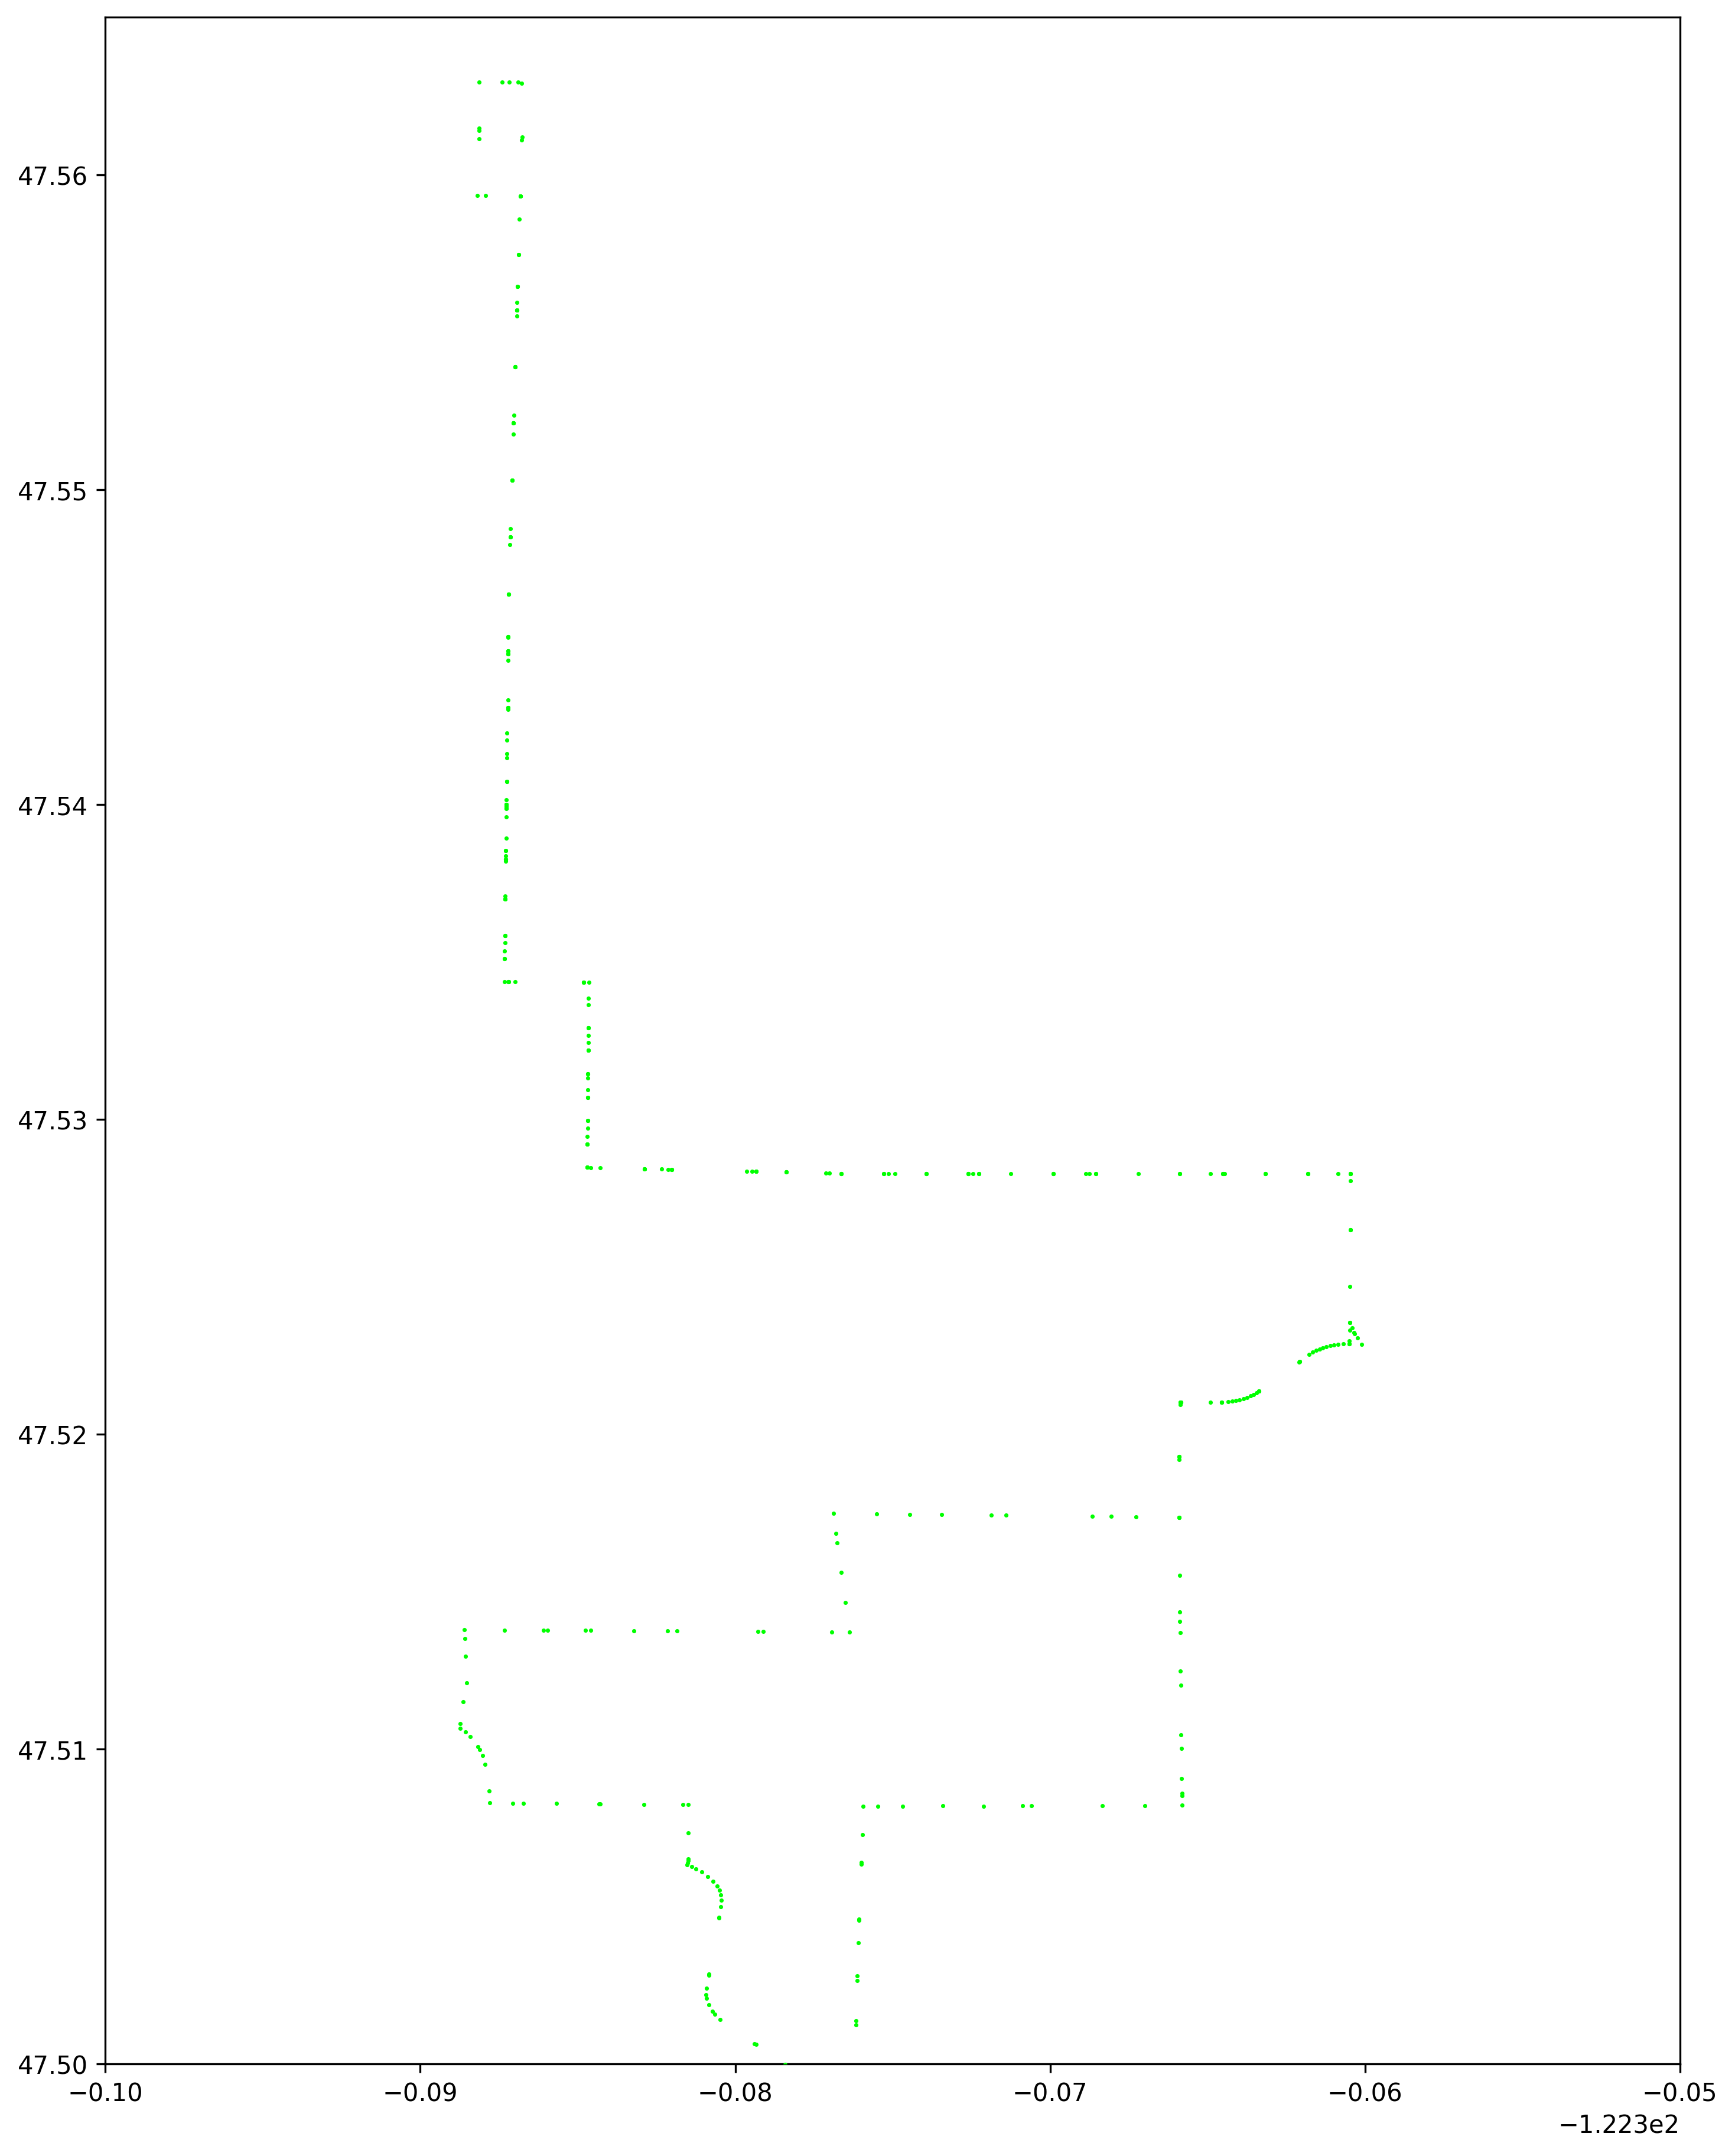

In [118]:
fig, ax = plt.subplots(1, figsize = (15, 15), dpi=300)
ax.set_xlim(-122.4, -122.350)
ax.set_ylim(47.5, 47.565)


seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]


#seattle.plot(color="orange", ax=ax, zorder = 20, alpha = .2)
geometry.plot(color="lime", ax=ax, zorder = 30, markersize=.5)
for index, row in f_gdf.iterrows():
    path = row['path'] + "_reproject.tif"
    filtered_raster_geometry = row['geometry']
    bounds = filtered_raster_geometry .bounds
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
    ds = gdal.Open(path)
    rasterArr = np.array(ds.GetRasterBand(1).ReadAsArray())
    with rasterio.open(path) as img:
        print(img.bounds)
        vals = rasterio.sample.sample_gen(img, [(-122.37,47.56), (-122.37,47.55), (-122.37,47.54)], masked=True)
        for elev in vals:
            print(str(type(elev[0])))
        
        show(img, ax=ax, cmap = 'gist_gray', zorder=15)
ax.set_xlim(-122.4, -122.350)
ax.set_ylim(47.5, 47.565)

    #rasterio.warp.reproject(img, src_crs ="NAD83(HARN) / Washington South (ftUS)", dst_crs = "EPSG:4326")
    #show(img, ax=ax)

In [178]:
benchmark_paths = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(benchmark_paths).to_crs(epsg = 4326)
all_benchmarks = {}
benchmark_list = []
benchmarks['ll_tuple'] = benchmarks['geometry'].apply(lambda x: (x.x, x.y))

for index, row in bound_gdf.iterrows():
    path = row['path'] + "_reproject.tif"
    with rasterio.open(path) as img:
        benchmarks['raster_elev'] = list(rasterio.sample.sample_gen(img, list(benchmarks['ll_tuple']), masked=True))
        filtered_benchmarks = benchmarks[benchmarks['raster_elev'].apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
        
        for row_2, col_2 in filtered_benchmarks.iterrows():
            data_dict = {'True_elevation':col_2['ELEVATION'], 'DTM_elevation':col_2['raster_elev'], 'DSM_elevation':None}
            all_benchmarks[row_2] = data_dict

In [179]:
pd.DataFrame(all_benchmarks)

,759,779,150,151,348,397,418,549,623,624,...,527,129,166,761,762,763,764,227,398,294
True_elevation,19.545,19.552,147.77,149.09,36.698,40.87,16.035,81.28,13.359,42.604,...,27.425,4.951,65.908,3.402,2.812,3.923,3.878,3.10,125.76,5.2
DTM_elevation,[218],[204],[169],[112],[221],[115],[221],[168],[229],[123],...,[193],[220],[170],[139],[232],[180],[217],[206],[109],[224]
DSM_elevation,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
vals = src.sample(coords)

In [199]:
fig.savefig("22_alignment_2.png")

In [100]:
str(route_bounds)

'POLYGON ((-122.38874290259594 47.49892287977223, -122.38874290259594 47.56294684155153, -122.36009950624877 47.56294684155153, -122.36009950624877 47.49892287977223, -122.38874290259594 47.49892287977223))'

In [116]:
#filtered_gdf = bound_gdf[bound_gdf['contains_route']==True]


'''
        asciitags = str(meta_dict['GeoAsciiParamsTag'])[2:-4].split("|")
        data_dict = {}
        data_dict['Upper_Left_CD'] = meta_dict['ModelTiepointTag'][3:5]
        for combined_tag in asciitags:

            try:
                split = combined_tag.split(" = ")
                key = split[0]
                value = split[1]
                data_dict[key] = value
            except:
                e = 1
        #print(meta_dict.keys())
        for key in list(meta_dict.keys()):
            if (key != "TileOffsets") and (key != "TileByteCounts"):
                print("{}  |>    {}".format(key, meta_dict[str(key)]))
        metadata_list.append(data_dict)

    #dem = rasterio.open(raster_subset)
    #dem_array = dem.read(1).astype('float64')
    #fig, ax = plt.subplots(1, figsize=(12, 12))
    #show(dem_array, cmap='Greys_r', ax=ax)
'''
#df = pd.DataFrame(metadata_list)
#df


'\n        asciitags = str(meta_dict[\'GeoAsciiParamsTag\'])[2:-4].split("|")\n        data_dict = {}\n        data_dict[\'Upper_Left_CD\'] = meta_dict[\'ModelTiepointTag\'][3:5]\n        for combined_tag in asciitags:\n\n            try:\n                split = combined_tag.split(" = ")\n                key = split[0]\n                value = split[1]\n                data_dict[key] = value\n            except:\n                e = 1\n        #print(meta_dict.keys())\n        for key in list(meta_dict.keys()):\n            if (key != "TileOffsets") and (key != "TileByteCounts"):\n                print("{}  |>    {}".format(key, meta_dict[str(key)]))\n        metadata_list.append(data_dict)\n\n    #dem = rasterio.open(raster_subset)\n    #dem_array = dem.read(1).astype(\'float64\')\n    #fig, ax = plt.subplots(1, figsize=(12, 12))\n    #show(dem_array, cmap=\'Greys_r\', ax=ax)\n'

In [24]:
import rasterio
from rasterio.plot import show

In [9]:
rasterio.open()

Series([], dtype: object)

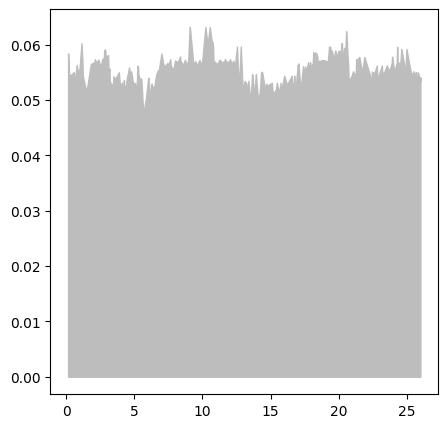

In [16]:
y = pd.Series(elevation, name='Z')*0.0003048
fig, ax = plt.subplots(1, figsize = (5, 5), dpi = 100)
ax.fill_between(x, y, color = '#BDBDBD')

In [ ]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)


In [70]:
filtered_elevations

,OBJECTID,GPS_Time,Northing,Easting,Height,YYYYMMDD,geometry
4914,4915,595567,249915.817,1282735.829,1477.828,20160326,POINT Z (-122.28532 47.67589 1477.82800)
4915,4916,595568,249848.274,1282507.102,1484.022,20160326,POINT Z (-122.28624 47.67569 1484.02200)
4916,4917,595569,249781.967,1282279.136,1494.327,20160326,POINT Z (-122.28716 47.67550 1494.32700)
4917,4918,595570,249716.913,1282051.758,1503.057,20160326,POINT Z (-122.28808 47.67531 1503.05700)
4918,4919,595571,249653.591,1281824.830,1511.886,20160326,POINT Z (-122.28900 47.67512 1511.88600)
...,...,...,...,...,...,...,...
347278,347279,421550,242366.190,1281663.530,5126.010,20160225,POINT Z (-122.28909 47.65514 5126.01000)
347279,347280,421551,242121.360,1281661.310,5126.030,20160225,POINT Z (-122.28908 47.65447 5126.03000)
347280,347281,421552,241877.290,1281658.770,5127.660,20160225,POINT Z (-122.28907 47.65380 5127.66000)
347281,347282,421553,241633.820,1281655.690,5128.060,20160225,POINT Z (-122.28907 47.65313 5128.06000)


In [ ]:
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))

In [ ]:
contours_data_dir = "./Data/Contours/"
contourfiles_raw = pd.Series(os.listdir(contours_data_dir))
contourfiles = contourfiles_raw[contourfiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
contourfiles = contourfiles.apply(lambda x: "{}{}".format(contours_data_dir, x))

In [20]:
contour = gpd.read_file(contourfiles[1]).to_crs(epsg = 4326)

In [ ]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=3000)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

for contour_subset in contourfiles:
    print(contour_subset)
    contour = gpd.read_file(contour_subset).to_crs(epsg = 4326)
    contour.plot(color="tab:orange", ax=ax, markersize=.1)
    del(contour)
    
plt.show()

./Data/Contours/t20r03_contour005.shp
./Data/Contours/t20r11_contour005.shp
./Data/Contours/t22r11_contour005.shp
./Data/Contours/t18r11_contour005.shp
./Data/Contours/t22r09_contour005.shp


In [16]:
elevations = elevations.to_crs(epsg = 4326)

<Axes: >

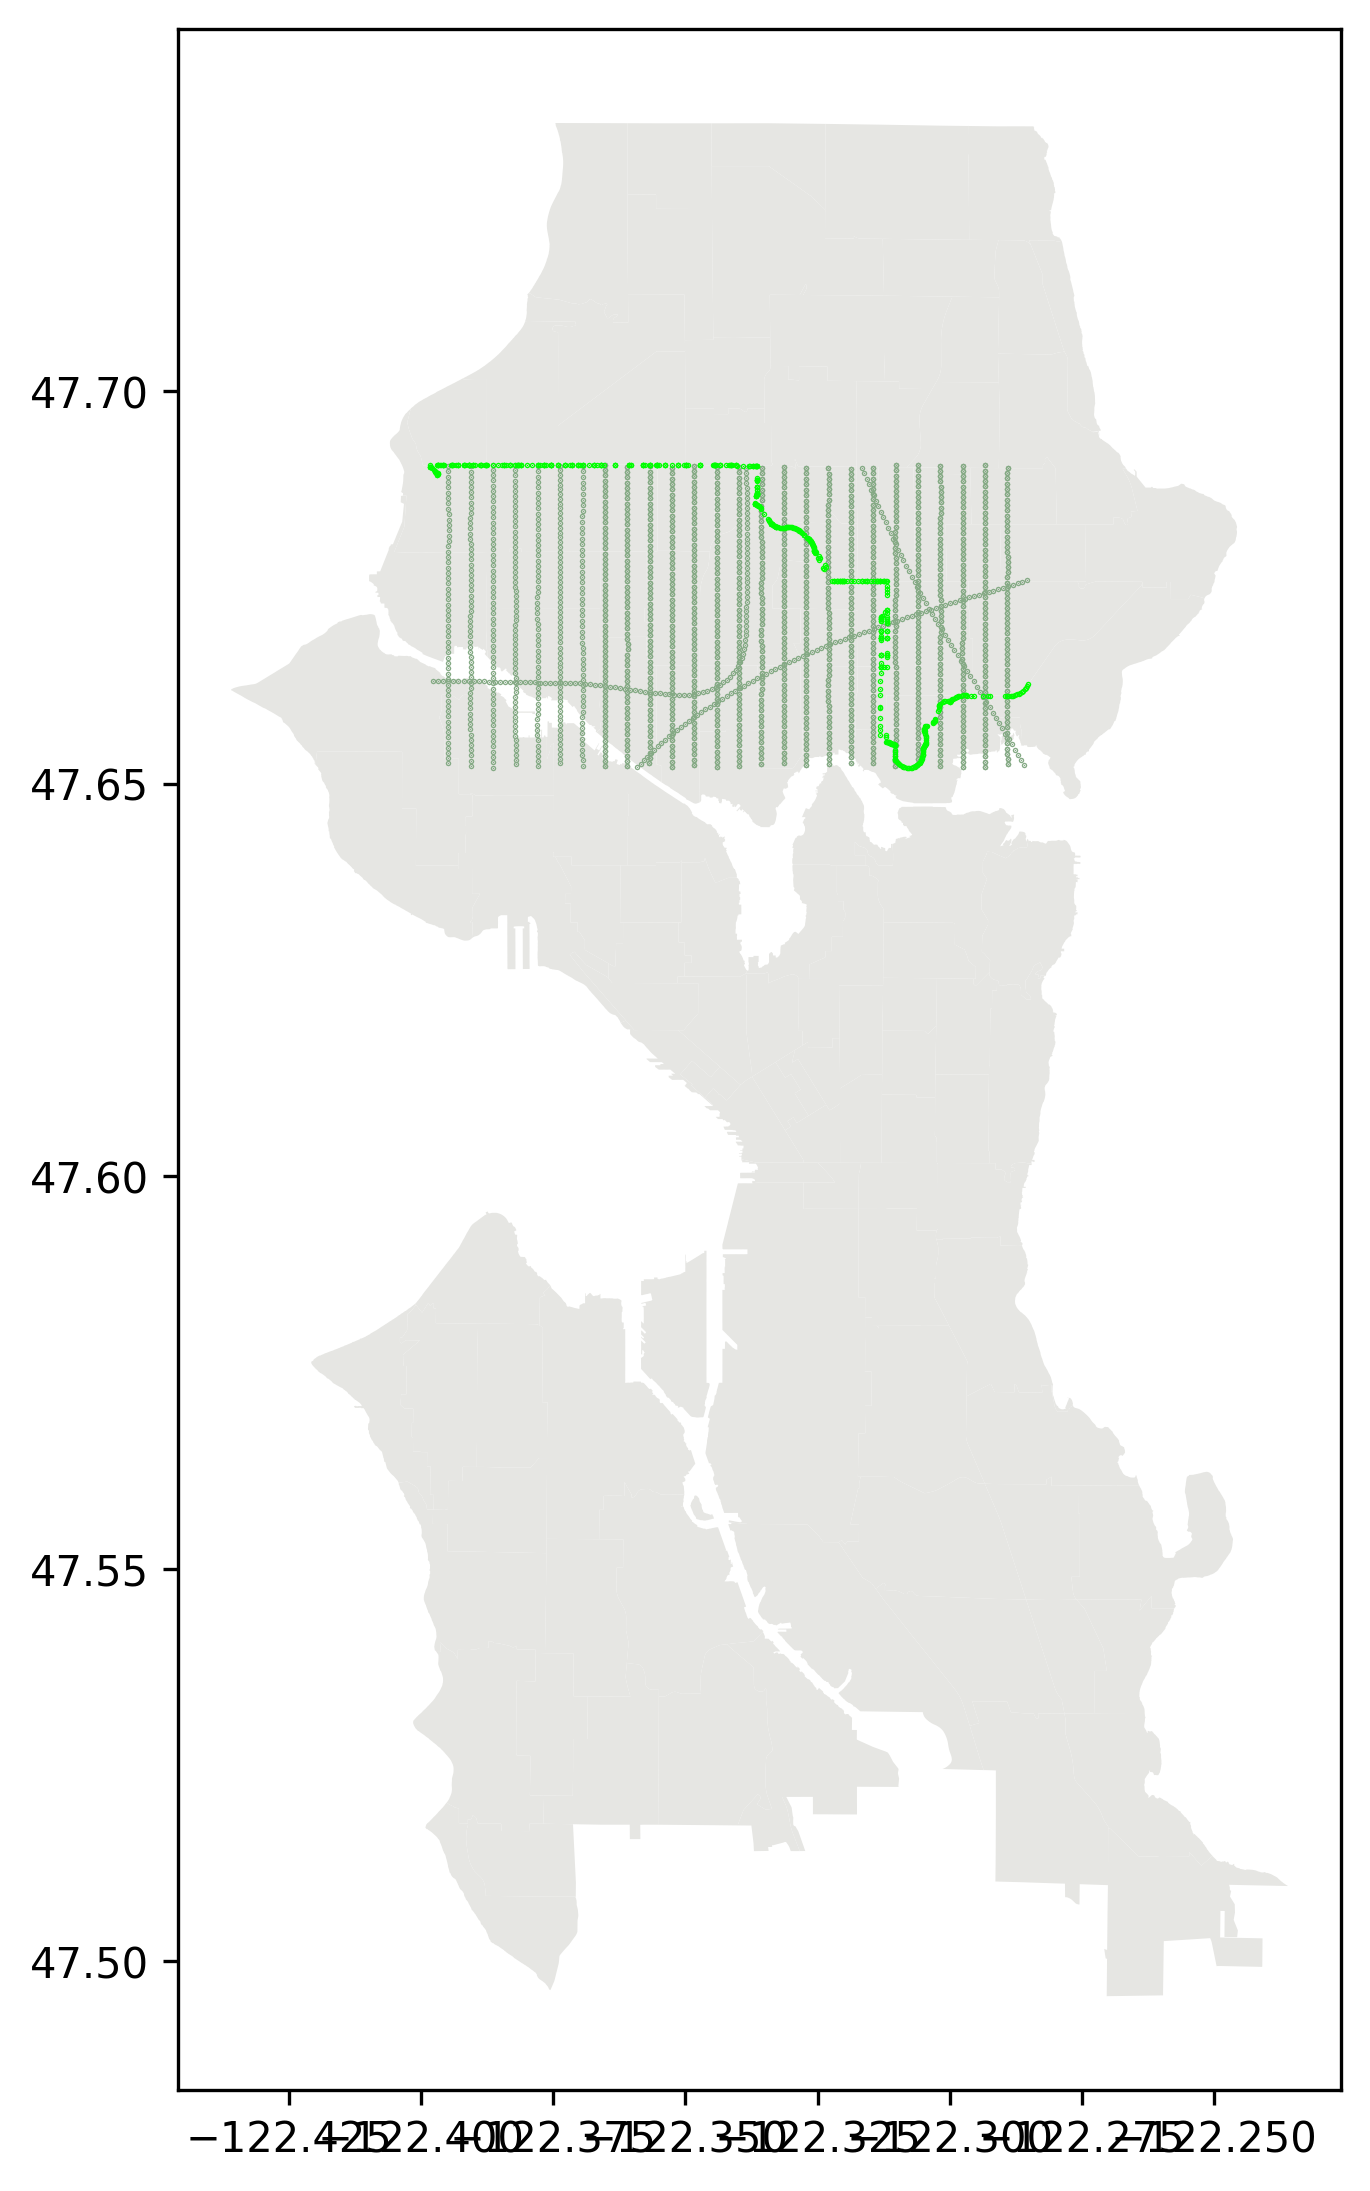

In [18]:
dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])


route_bounds = hm.get_bounding_box(shapely.LineString(geometry))
filtered_elevations = elevations[(elevations['geometry']).apply(lambda x: shapely.contains(route_bounds, x)) == True]

seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)
filtered_elevations.plot(color="#85AA85", ax=ax, zorder=.5, markersize=.1)


In [76]:
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from qgis.core import *
from qgis.utils import iface

project = QgsProject.instance() 
mFile=QFileInfo("C://Users//fran//Desktop//test.qgs")

project.write(mFile)

project.clear()

project.read(mFile)

ModuleNotFoundError: No module named 'qgis'

In [74]:
!pip3 install pyqt5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 35.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 21.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 15.8 MB/s eta 0:00:00


In [75]:
!pip3 install qgis

ERROR: Could not find a version that satisfies the requirement qgis (from versions: none)
ERROR: No matching distribution found for qgis
